# Assignment 2: Classification
# Using Machine Learning Tools

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are: 

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise data and determine the best pre-processing;
- to create the necessary datasets for training and testing purposes;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task. Note that some questions require writing a small amount of code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code runs correctly on the original data file.

Some of the parts of this assignment build on the workflow from the first assignment and that part of the course, and so less detailed instructions are provided for this, as you should be able to implement this workflow now without low-level guidance. A substantial portion of the marks for this assignment are associated with making the right choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and certain restrictions on sklearn functions will be made clear in the instruction text. You are expected to search and carefully read the documentation for functions that you use, to ensure you are using them correctly.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. This makes their method much faster than existing ones, but it is also slightly noisier. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 1) have at least a 95% probability of detecting malignant cancer when it is present;
 2) have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant).
 
They have hand-labelled 300 samples for you, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail, as appropriate to the marks given.

## 1. Investigate Dataset (10% = 3 marks)

In [1]:
# This code imports some libraries that you will need. 
# You should not need to modify it, though you are expected to make other imports later in your code.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time

# Pandas for overview
import pandas as pd

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

### 1.1 Load the dataset [0.5 marks]
Do this from the csv file, `assignment2.csv`, as done in assignment 1 and workshops 2 and 3. Extract the feature names and label names for use later on.  Note that we will be treating the _malignant_ case as our _positive_ case, as this is the standard convention in medicine.

**Print out some information (in text) about the data, to verify that the loading has worked and to get a feeling for what is present in the dataset and the range of the values.**

**Also, graphically show the proportions of the labels in the whole dataset.**

In [2]:
# Your code here
# Load the data
cancer = pd.read_csv("assignment2.csv")
cancer.head()

label  mean radius  mean texture  mean perimeter   mean area  \
0  malignant    15.494654     15.902542      103.008265  776.437239   
1  malignant    16.229871     18.785613      105.176755  874.712003   
2  malignant    16.345671     20.114076      107.083804  872.563251   
3  malignant    13.001009     19.876997       85.889775  541.281012   
4  malignant    16.416060     17.397533      107.857386  891.516818   

   mean smoothness  mean compactness  mean concavity  mean concave points  \
0         0.104239          0.168660        0.170572             0.085668   
1         0.091843          0.092548        0.081681             0.053670   
2         0.099924          0.123799        0.128788             0.078310   
3         0.113423          0.173069        0.146214             0.069574   
4         0.097321          0.111530        0.125971             0.068575   

   mean symmetry  ...  worst radius  worst texture  worst perimeter  \
0       0.205053  ...     19.522957      22.427276       135.128520   
1       0.180435  ...     19.140235      24.905156       123.886045   
2       0.189756  ...     19.144816      25.601433       125.113036   
3       0.212078  ...     15.565911      26.145119       102.958265   
4       0.179562  ...     18.620376      22.306233       124.002529   

    worst area  worst smoothness  worst compactness  worst concavity  \
0  1286.903131          0.142725           0.407483         0.445992   
1  1234.499997          0.129135           0.223918         0.248846   
2  1202.749973          0.135017           0.314402         0.332505   
3   737.655082          0.161390           0.485912         0.430007   
4  1139.490971          0.133950           0.230996         0.316620   

   worst concave points  worst symmetry  worst fractal dimension  
0              0.171662        0.353211                 0.097731  
1              0.136735        0.284427                 0.085758  
2              0.161497        0.313038                 0.084340  
3              0.167254        0.432297                 0.117705  
4              0.131715        0.269591                 0.080497  

[5 rows x 31 columns]

In [3]:
# get familiar with the data
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    300 non-null    object 
 1   mean radius              300 non-null    float64
 2   mean texture             300 non-null    float64
 3   mean perimeter           300 non-null    float64
 4   mean area                300 non-null    float64
 5   mean smoothness          300 non-null    float64
 6   mean compactness         300 non-null    float64
 7   mean concavity           300 non-null    float64
 8   mean concave points      300 non-null    float64
 9   mean symmetry            300 non-null    float64
 10  mean fractal dimension   300 non-null    float64
 11  radius error             300 non-null    float64
 12  texture error            300 non-null    float64
 13  perimeter error          300 non-null    float64
 14  area error               3

In [4]:
dataframe_size = cancer.shape[0]
print("Cancer dataset has:", dataframe_size,"entries")
size_of_feature = len(cancer.columns)
print("Cancer dataset has:", size_of_feature,"features")
cancer_label= cancer['label'].value_counts(normalize=True)
plt.title("Distribution of Diagnosis")
plt.pie(cancer_label,labels=cancer_label.index,autopct="%.2f%%")
plt.show()

Cancer dataset has: 300 entries
Cancer dataset has: 31 features


Cancer dataset have 300 entries and 31 columns.
Target variable is named as "label" and have categorical variable. It carries two classes which are <b>malignant</b> and <b>benign</b>. 
Label column later will be change to 1 for positive and 0 for negative. in this case malignant will carry as <b>1</b>
and benign will carry as <b>0</b>.
The rest of the columns are numerical type values.

In [5]:
# check the range of the cancer data
cancer.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   300.000000    300.000000      300.000000   300.000000   
mean     14.231808     19.312619       92.727687   664.367372   
std       1.297393      1.572224        8.949937   129.515717   
min      11.560025     15.349270       74.690886   477.371592   
25%      13.356676     18.194791       86.659535   580.383274   
50%      13.976933     19.220652       90.896982   628.004851   
75%      15.103078     20.245660       99.093762   737.444716   
max      19.090091     26.836291      126.168030  1300.788708   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       300.000000        300.000000      300.000000           300.000000   
mean          0.096937          0.106615        0.092591             0.050820   
std           0.005067          0.020819        0.030312             0.014350   
min           0.084651          0.075184        0.050771             0.028701   
25%           0.093305          0.091105        0.069071             0.039507   
50%           0.096722          0.102401        0.084829             0.046744   
75%           0.099995          0.117334        0.107994             0.060606   
max           0.114500          0.192880        0.212704             0.105212   

       mean symmetry  mean fractal dimension  ...  worst radius  \
count     300.000000              300.000000  ...    300.000000   
mean        0.182546                0.062841  ...     16.460566   
std         0.010754                0.002736  ...      1.798202   
min         0.157059                0.057830  ...     13.279265   
25%         0.175353                0.060950  ...     15.148044   
50%         0.181685                0.062477  ...     16.007171   
75%         0.187789                0.064149  ...     17.656889   
max         0.226448                0.076091  ...     22.676185   

       worst texture  worst perimeter   worst area  worst smoothness  \
count     300.000000       300.000000   300.000000        300.000000   
mean       25.772128       108.563914   900.644633          0.133424   
std         2.346310        12.500033   209.738842          0.008678   
min        20.144214        87.110184   633.771881          0.110342   
25%        24.058893        99.229249   752.124790          0.127682   
50%        25.689861       105.540619   828.667704          0.133064   
75%        27.333610       116.274995  1011.628413          0.138650   
max        34.614459       150.353232  1796.820974          0.164583   

       worst compactness  worst concavity  worst concave points  \
count         300.000000       300.000000            300.000000   
mean            0.261732         0.282075              0.118146   
std             0.063535         0.079831              0.024552   
min             0.167098         0.152272              0.066927   
25%             0.215767         0.219671              0.098389   
50%             0.247022         0.267894              0.115679   
75%             0.298732         0.325278              0.136687   
max             0.543118         0.635074              0.179794   

       worst symmetry  worst fractal dimension  
count      300.000000               300.000000  
mean         0.293620                 0.084556  
std          0.025620                 0.007427  
min          0.240341                 0.072745  
25%          0.277676                 0.079636  
50%          0.288994                 0.082610  
75%          0.305227                 0.087645  
max          0.432297                 0.128288  

[8 rows x 30 columns]

### 1.2 Visualise the dataset [1.5 marks]

As this data is well curated by the client already, you do not need to worry about outliers, missing values or imputation in this case, but be aware that this is the exception, not the rule.

To familiarise yourself with the nature and information contained in the data, display histograms for the data according to the following instructions:
 - **display histograms** for each feature in the _mean_ group, but on _each_ histogram **have the two classes displayed together in one plot** (see example plot below and a code fragment to help you) - and note that your plot does not need to look exactly the example here;
 - **repeat this** for the _standard error_ and _worst_ groups;
 - make sure that in all cases you clearly label the plots and the classes in histograms.

<center><img src="Example_Hist_Plot.png" width="300" alt="Example plot of histogram"></center>

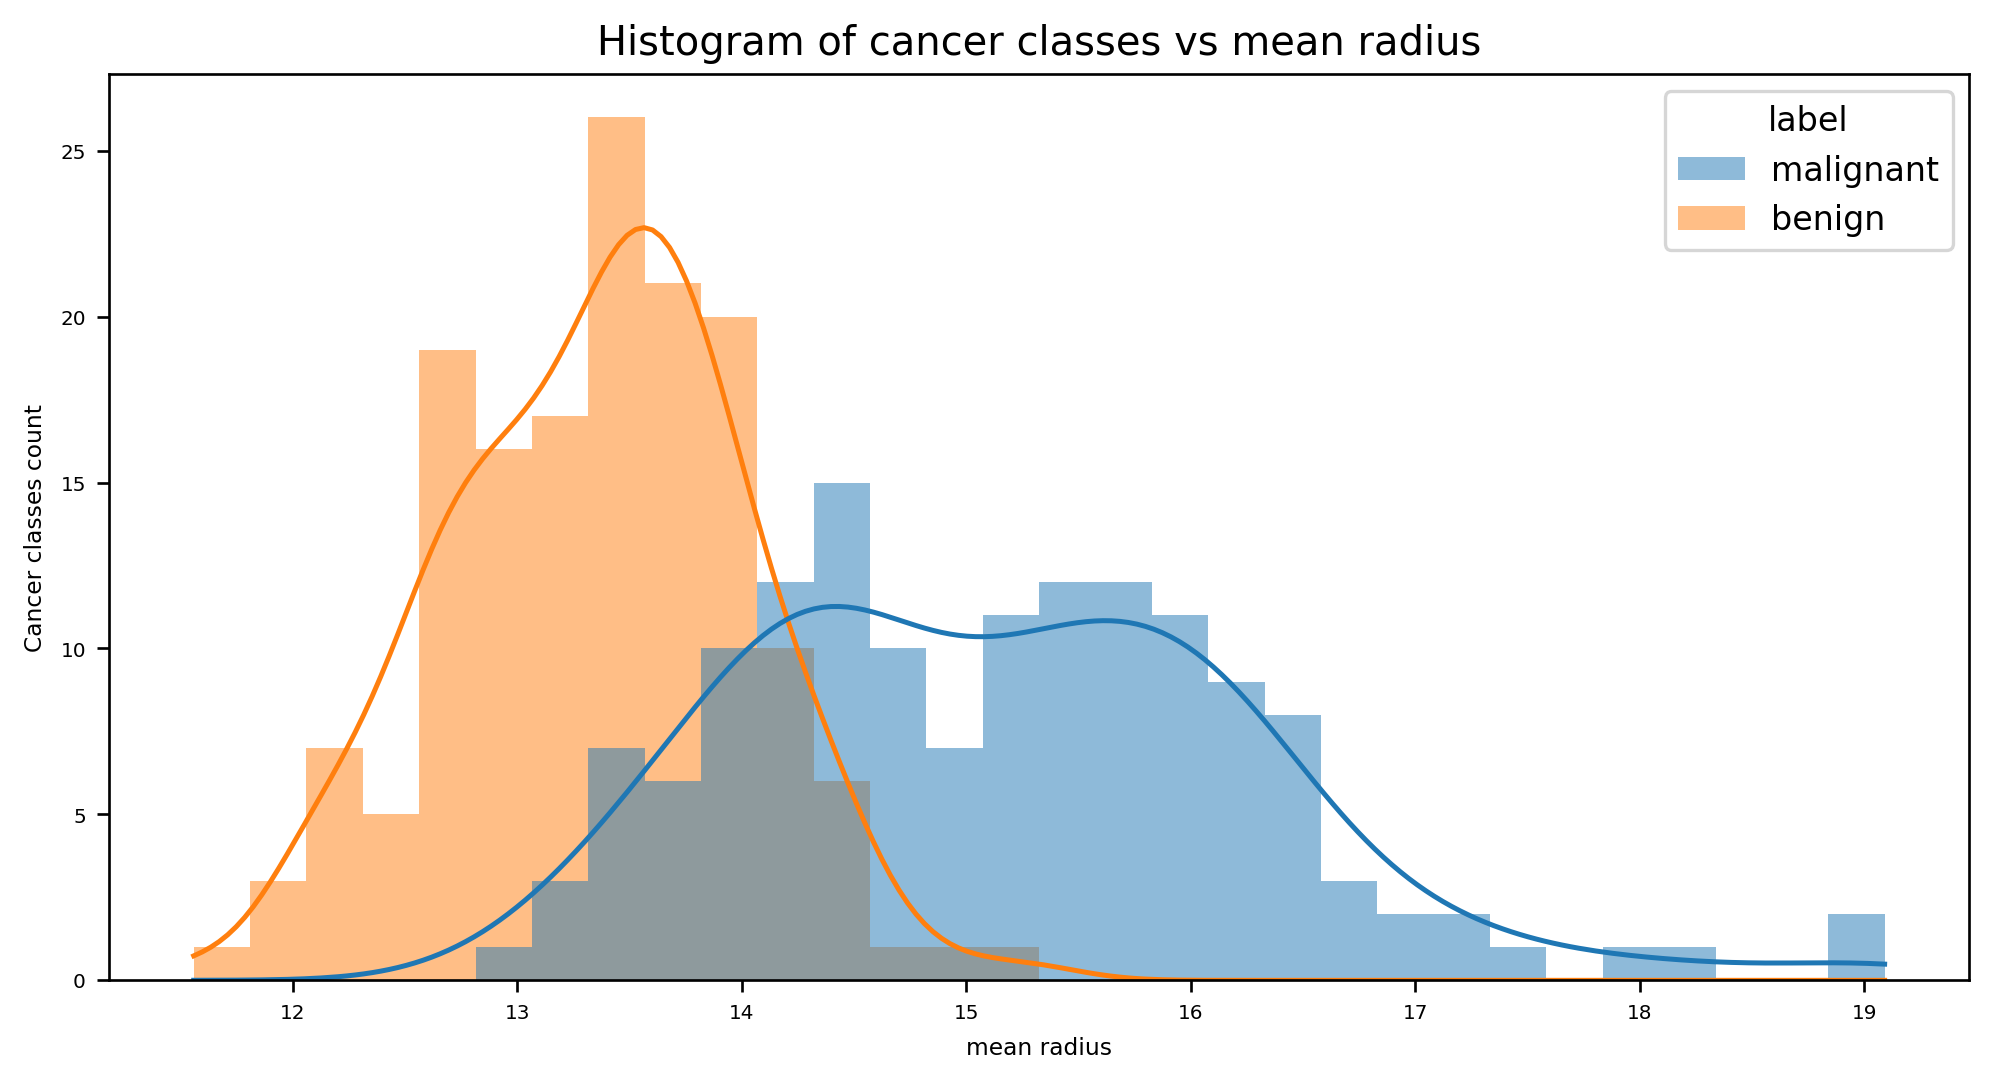

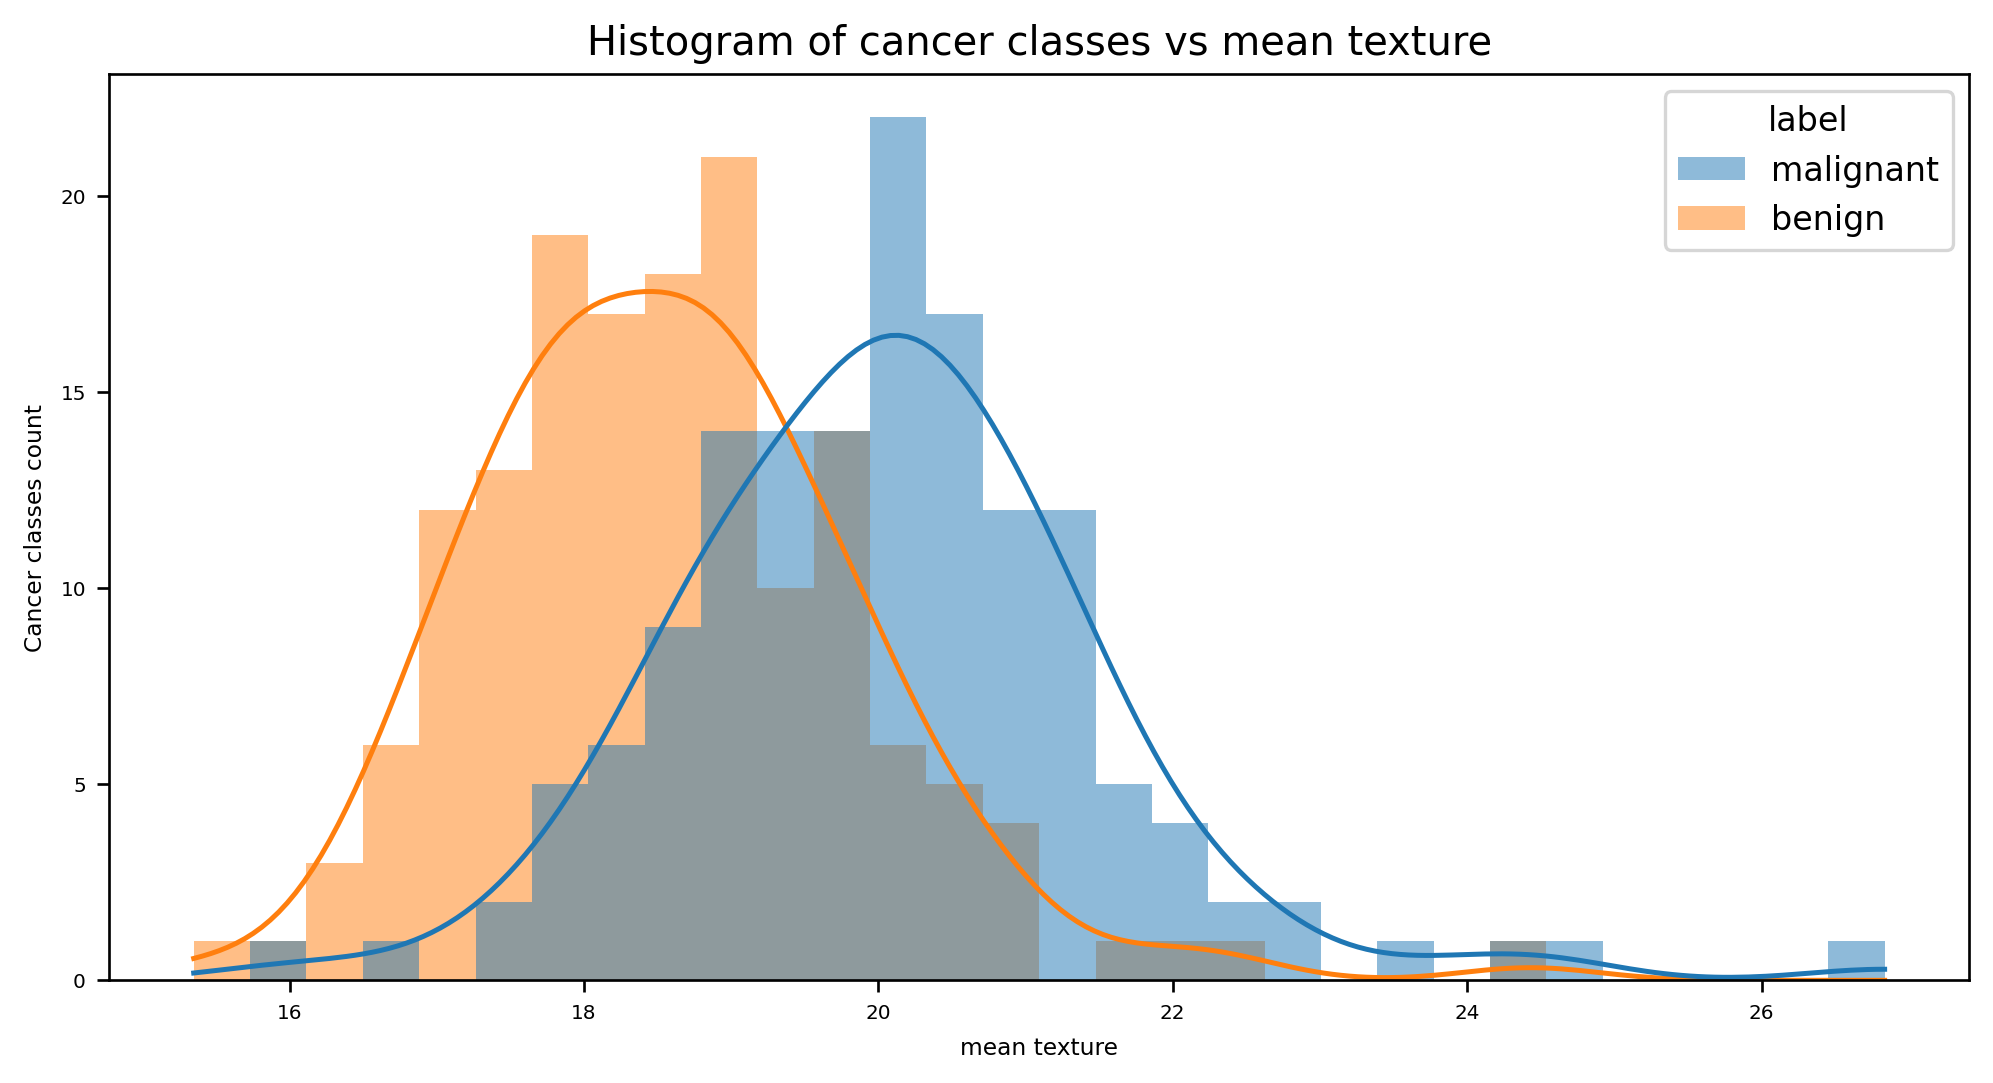

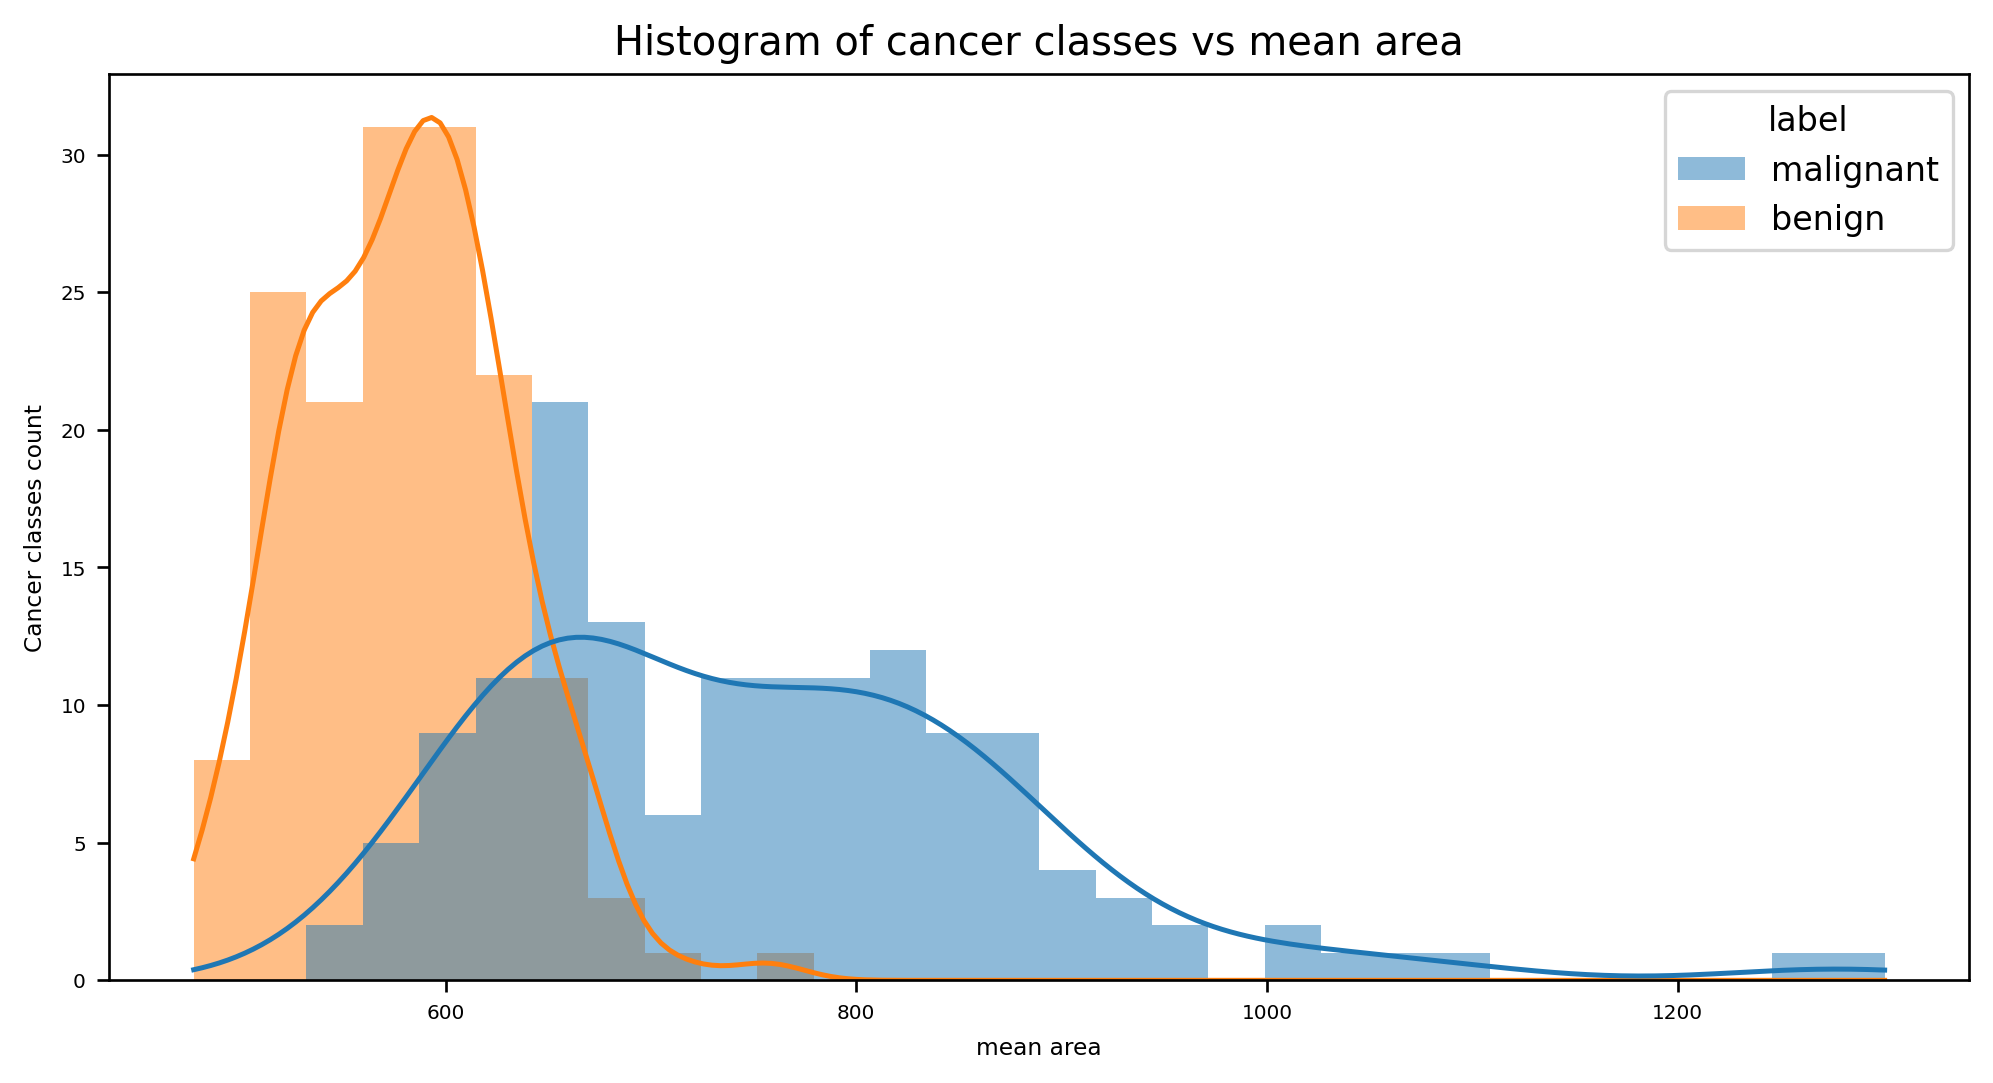

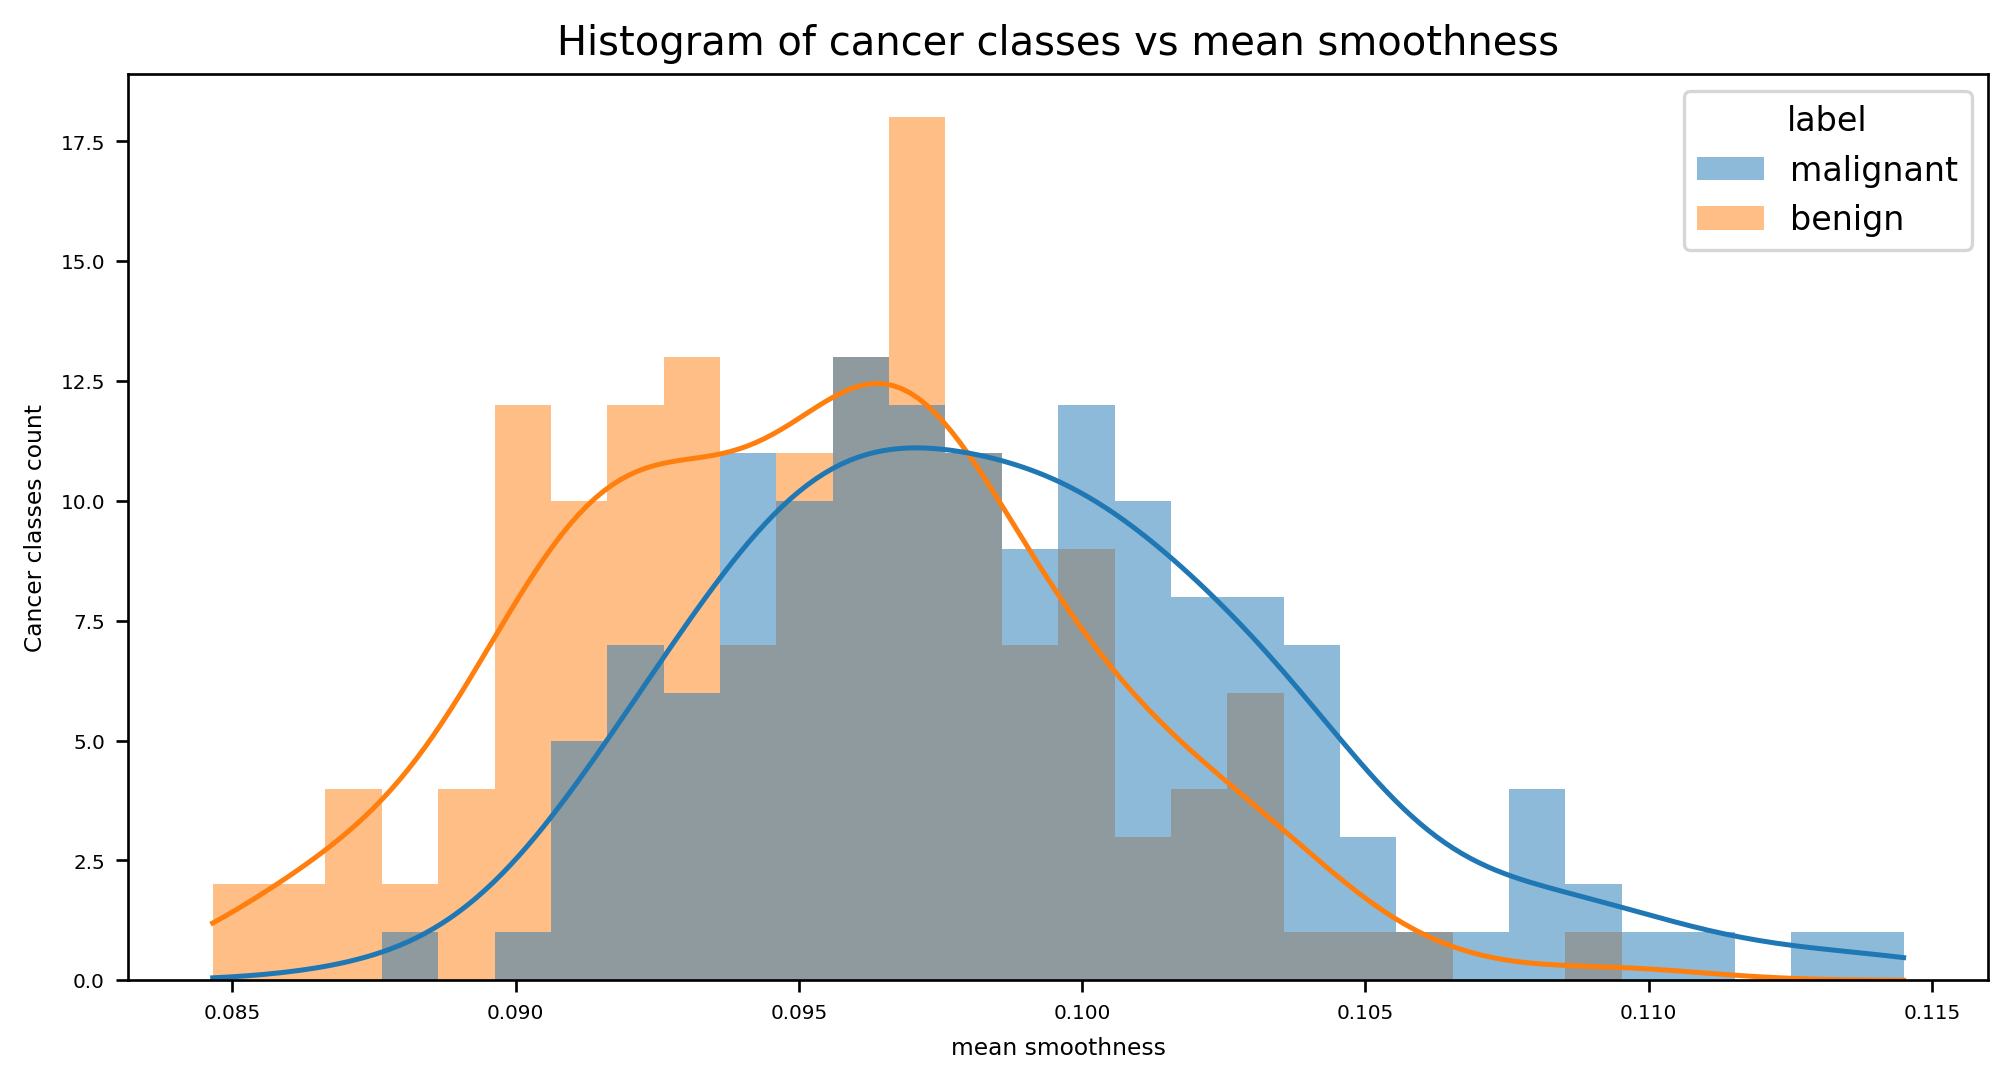

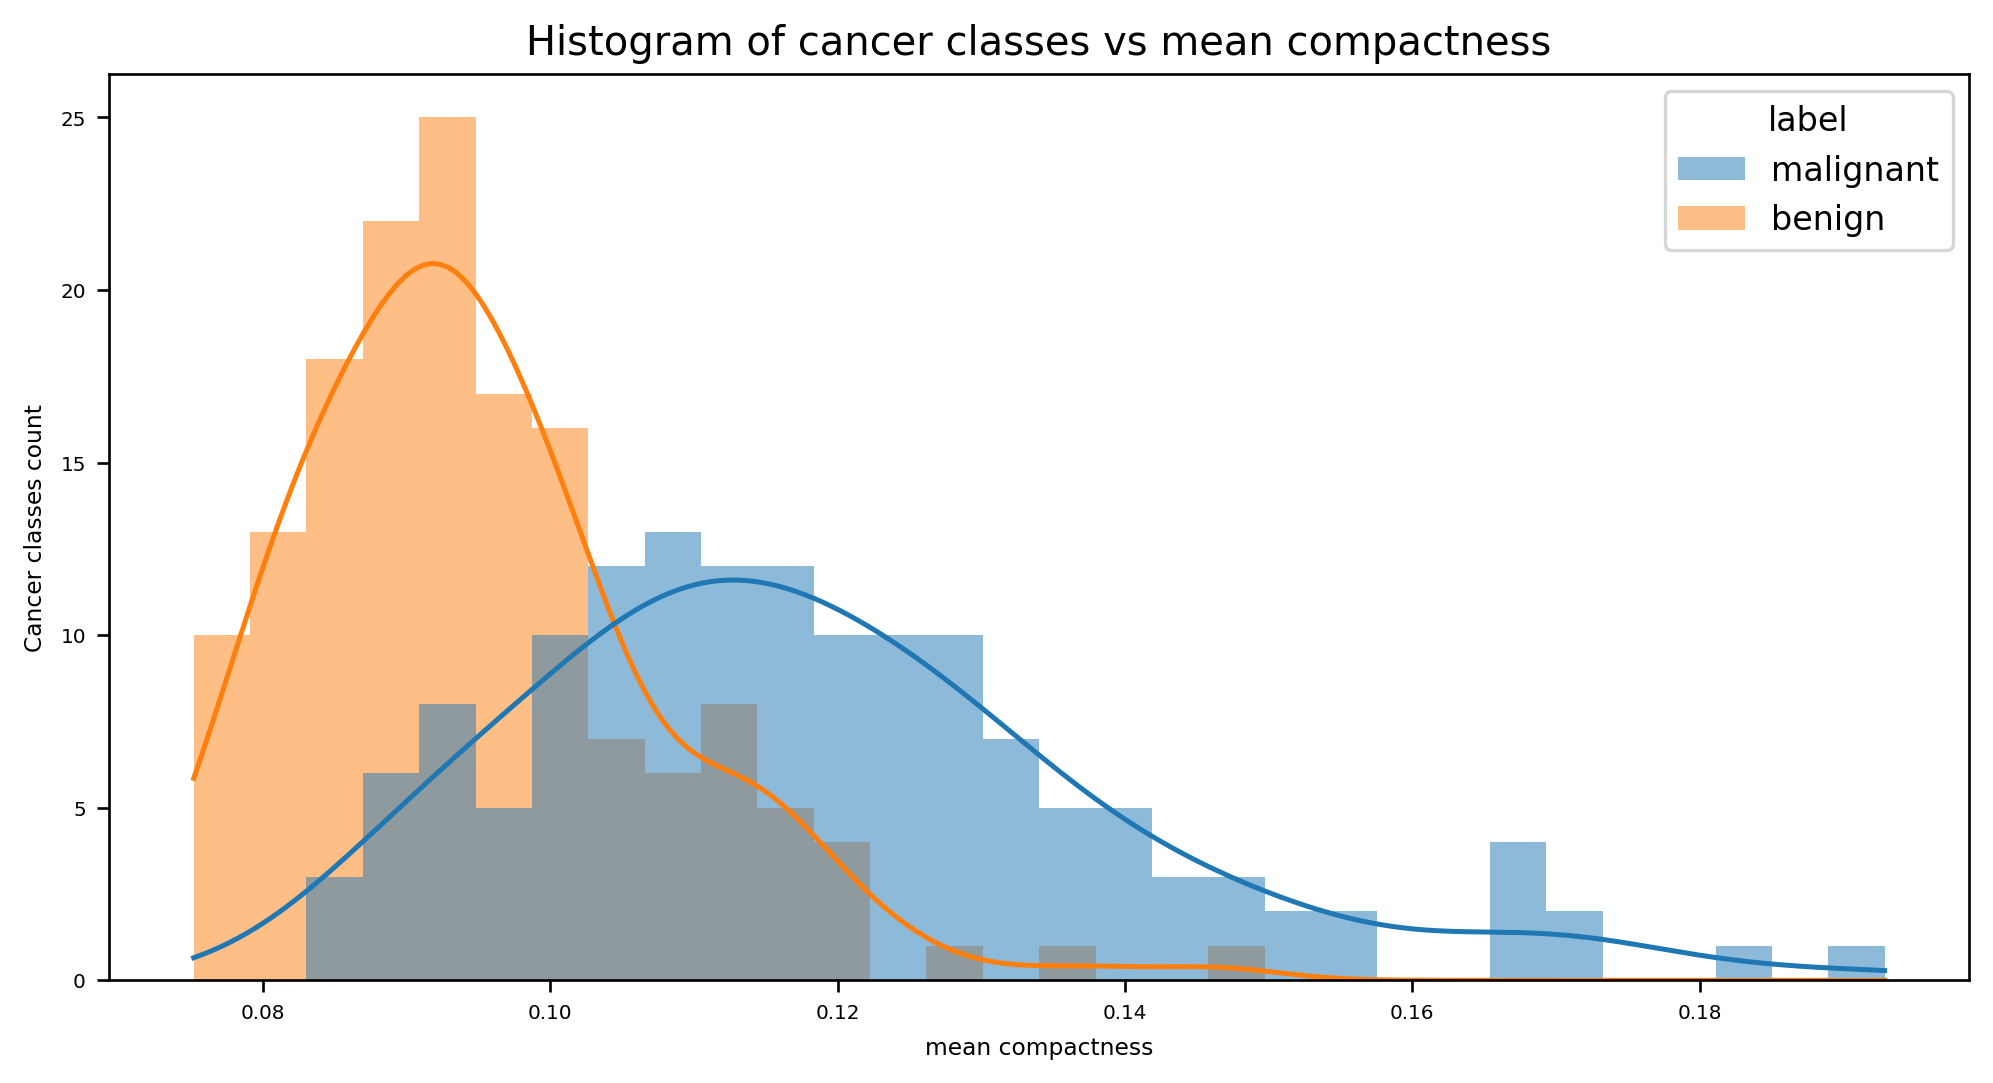

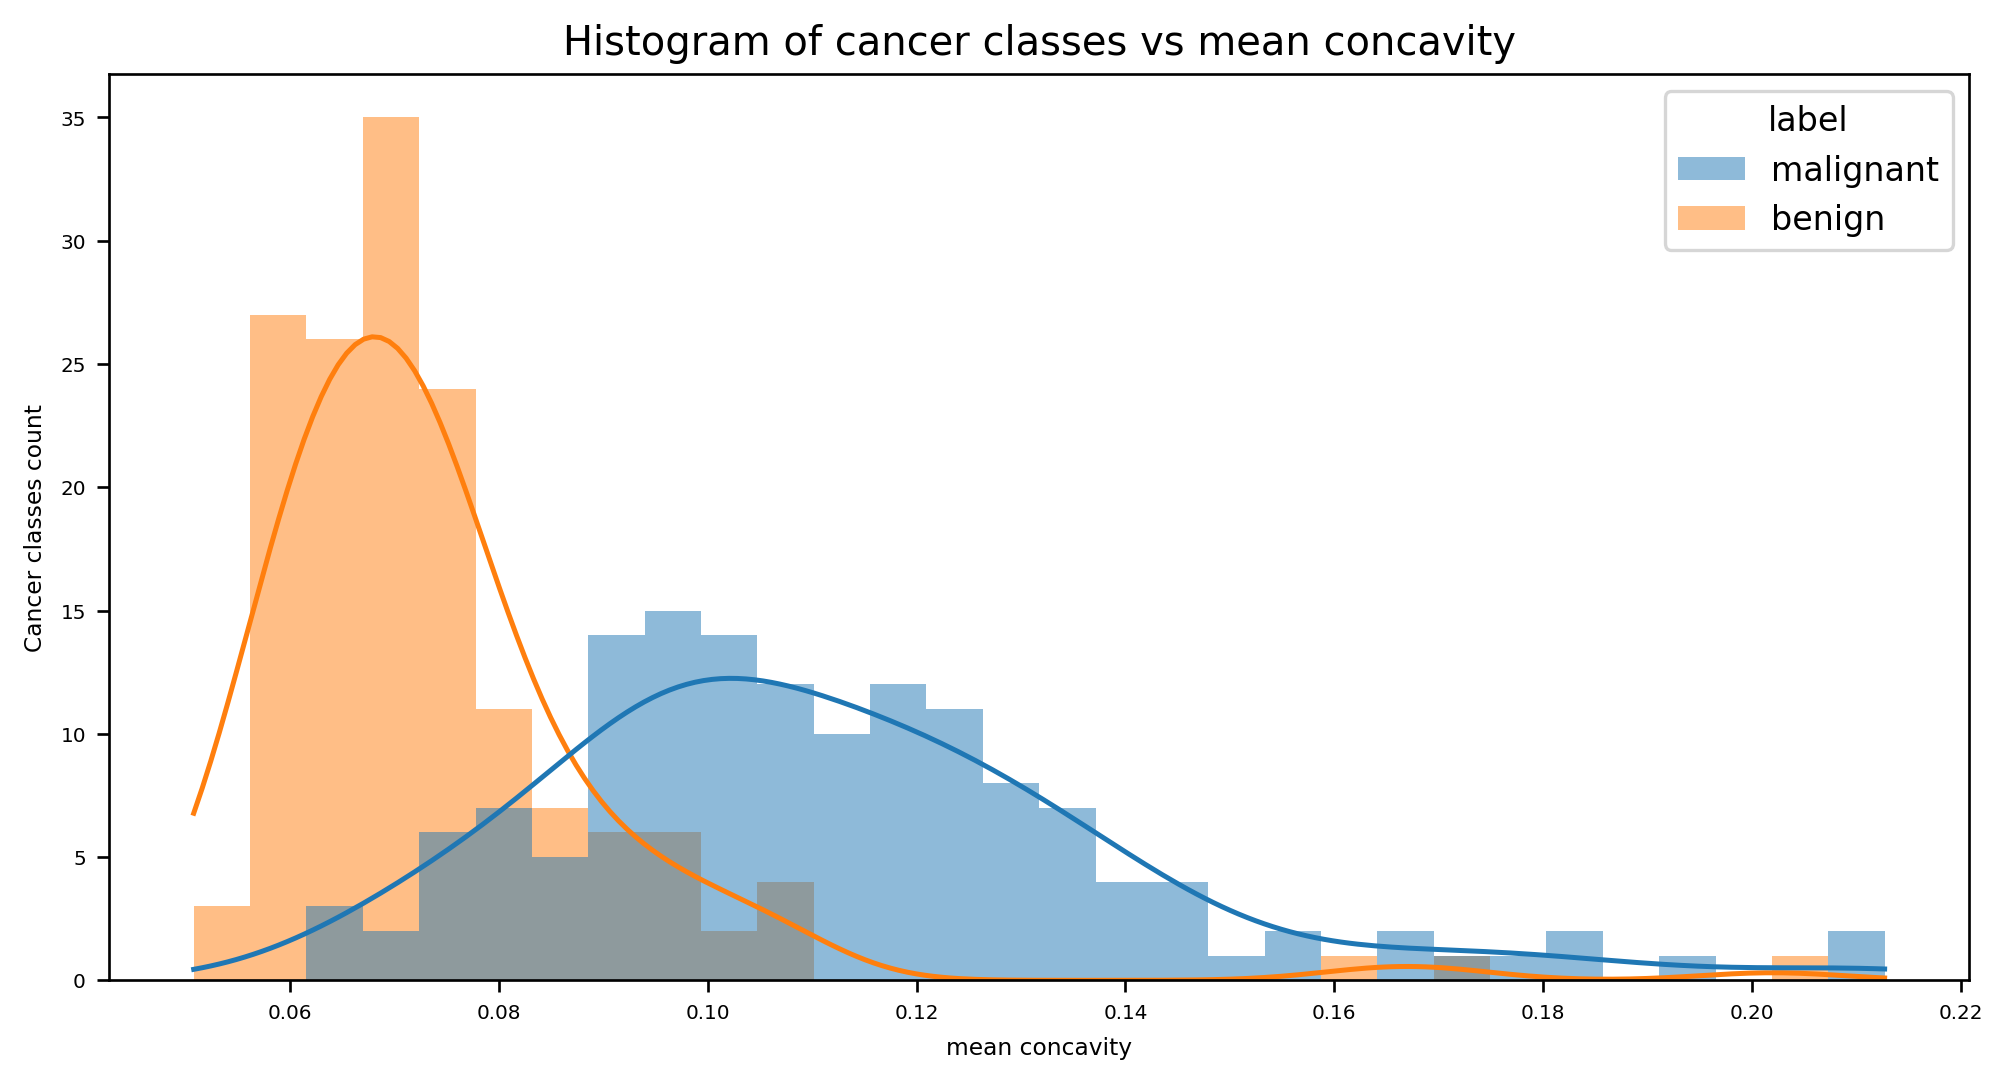

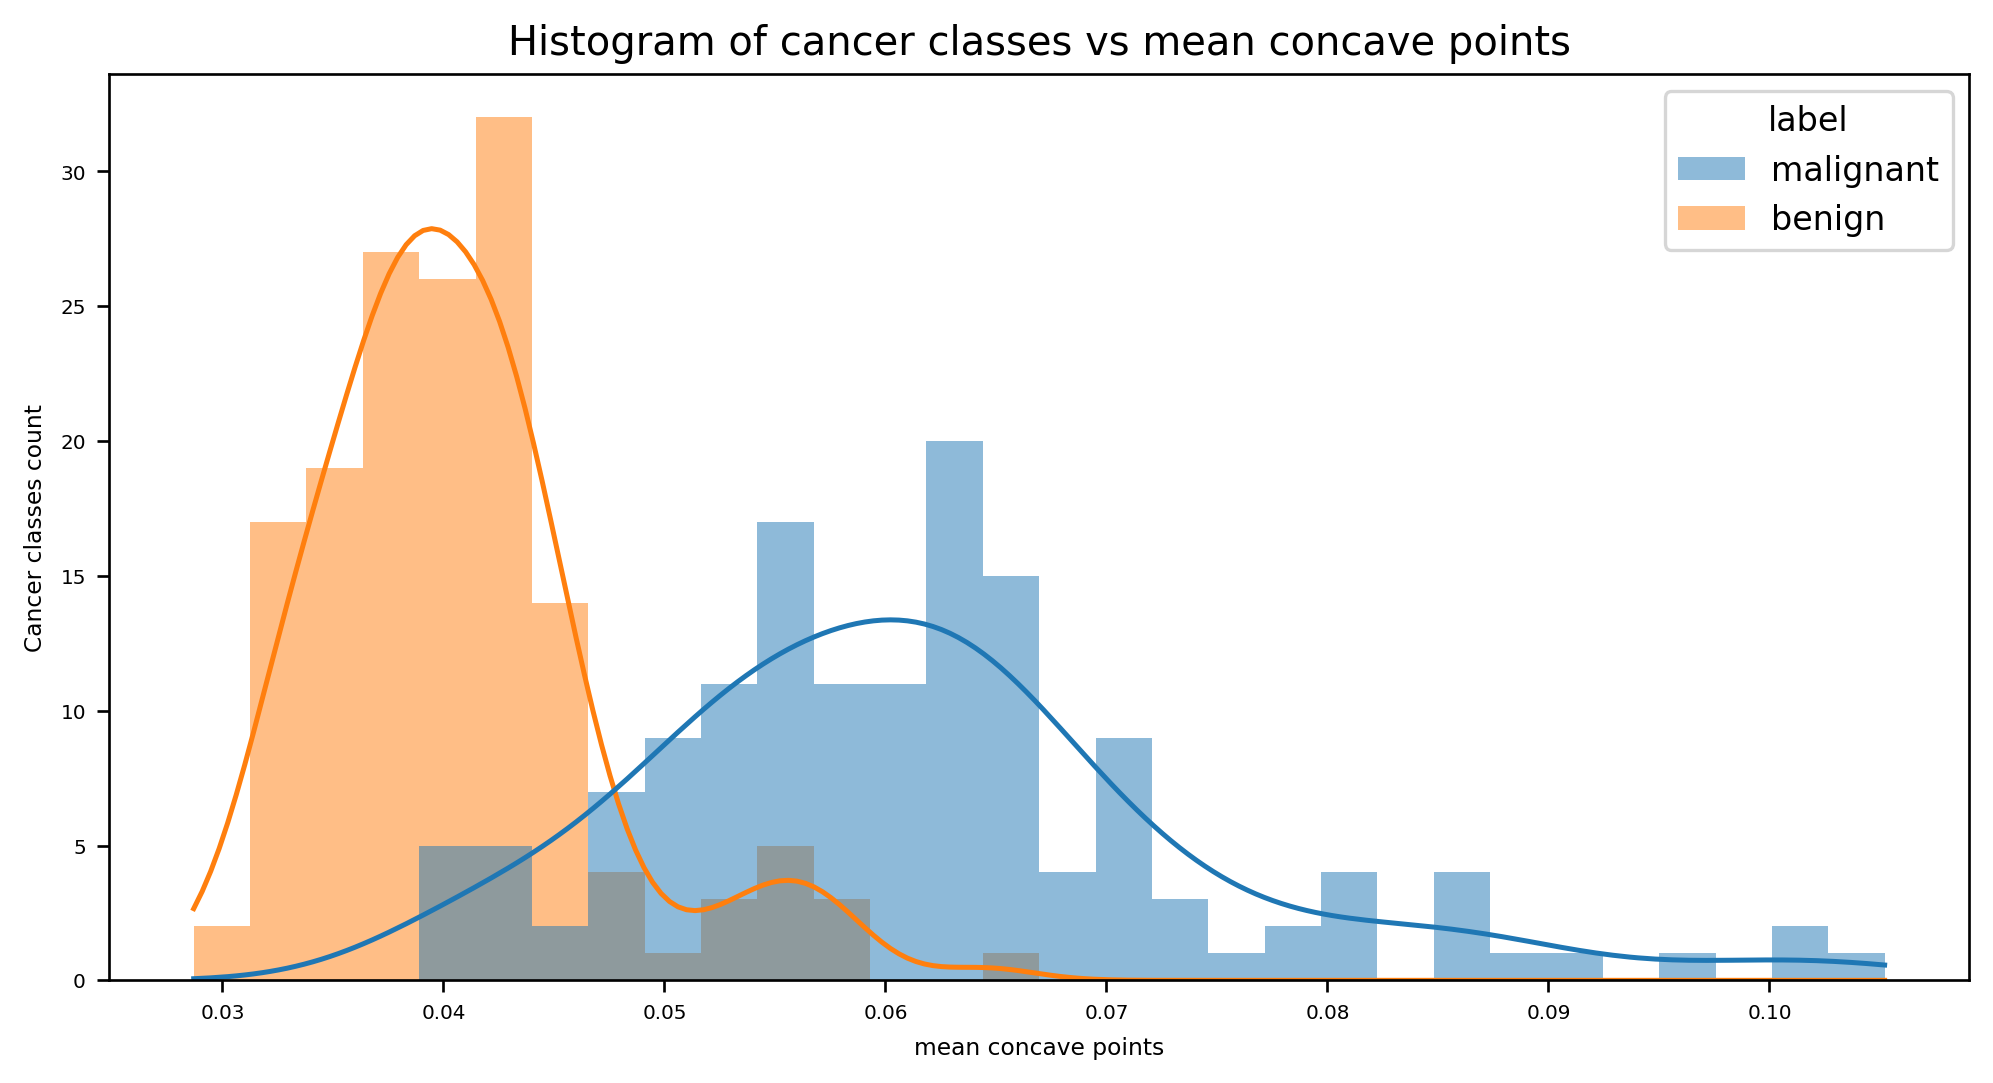

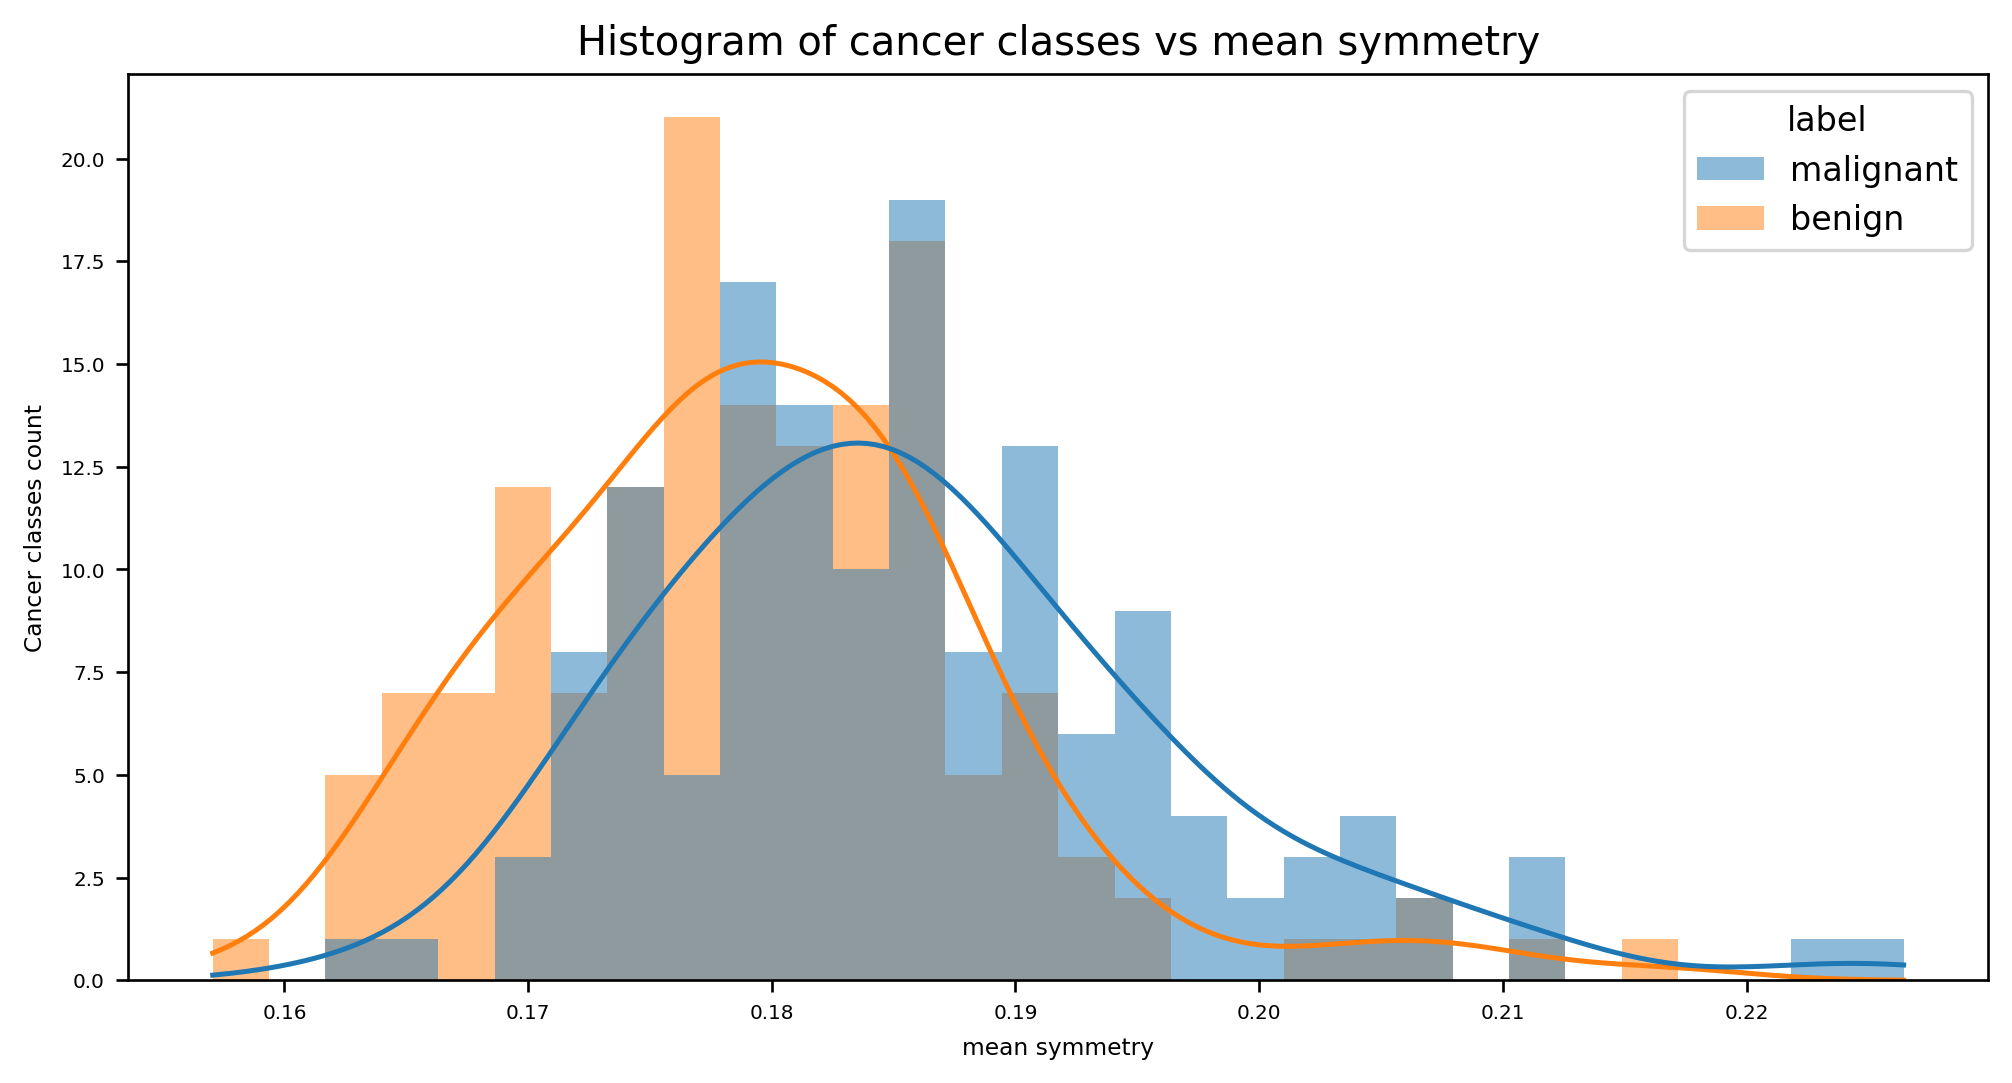

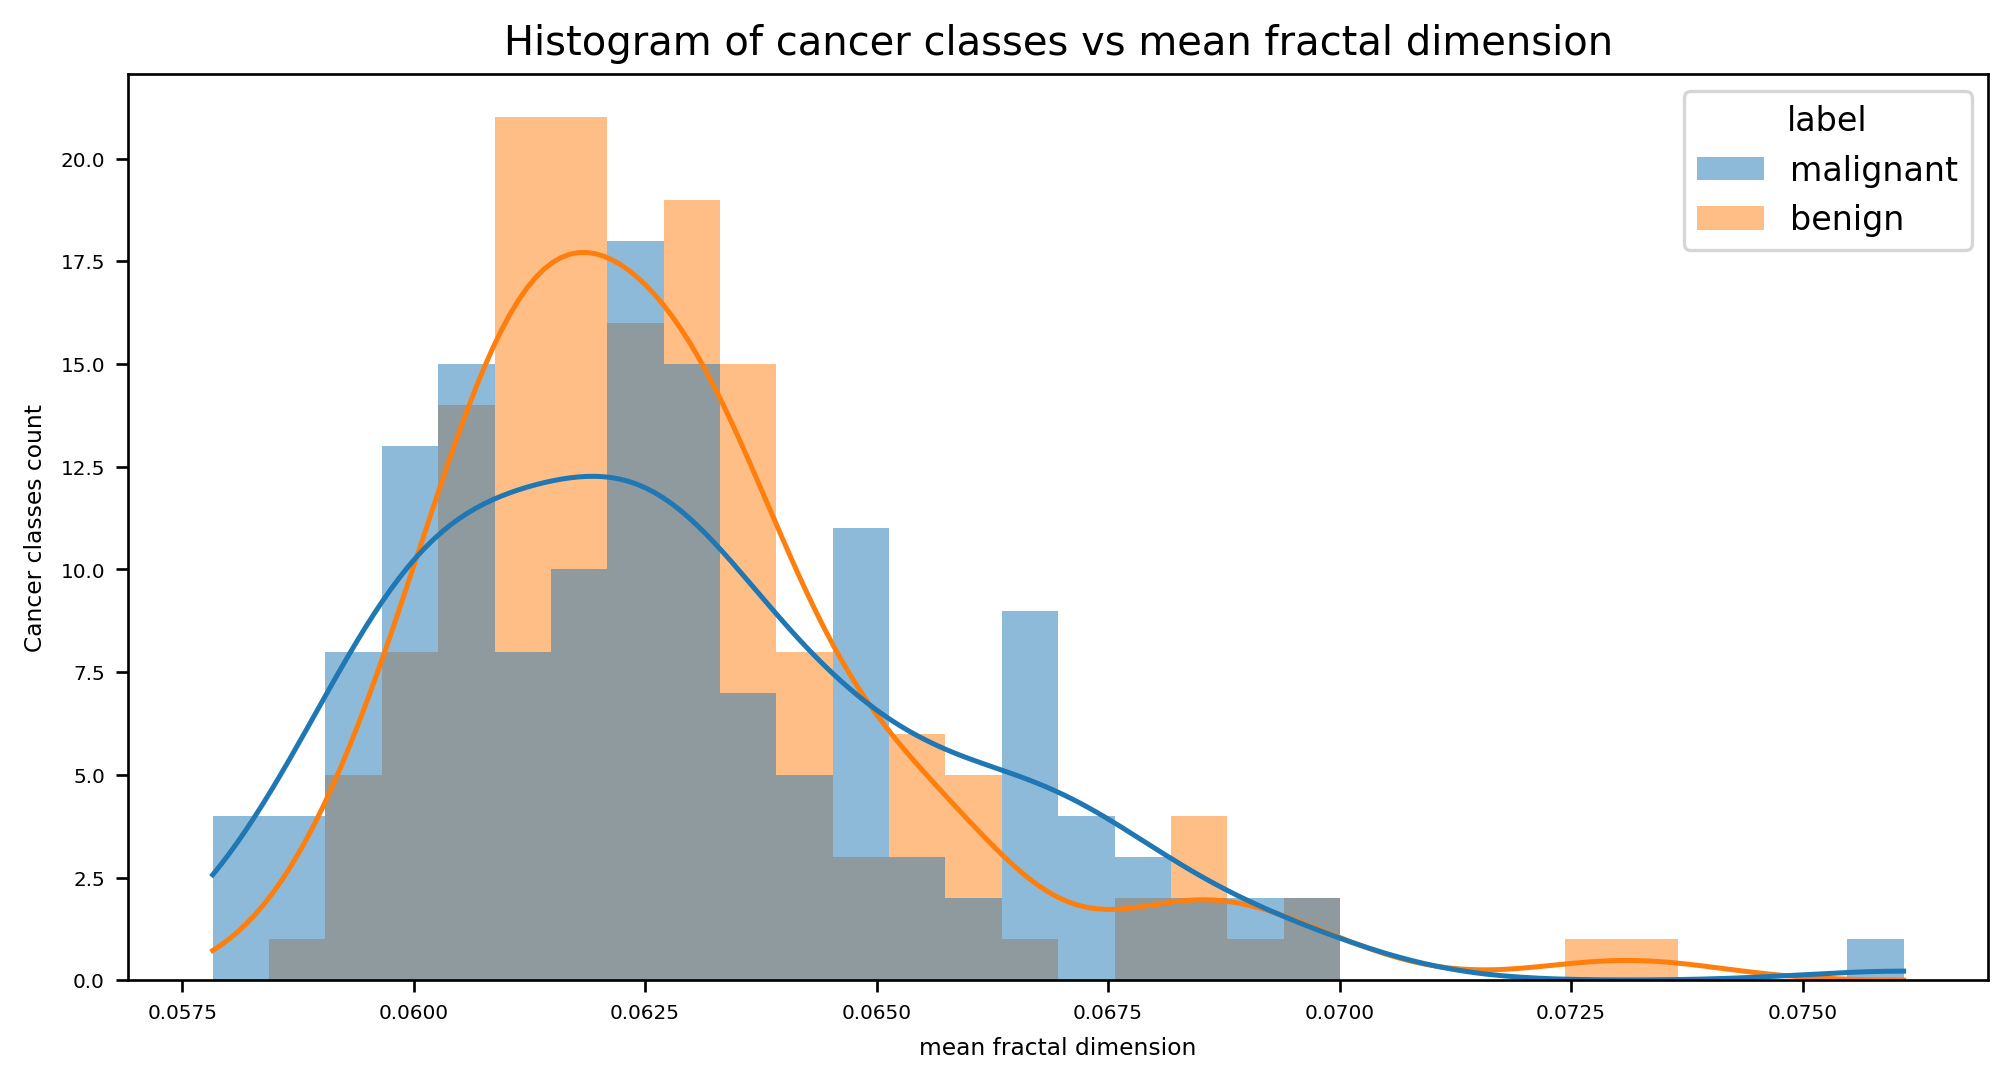

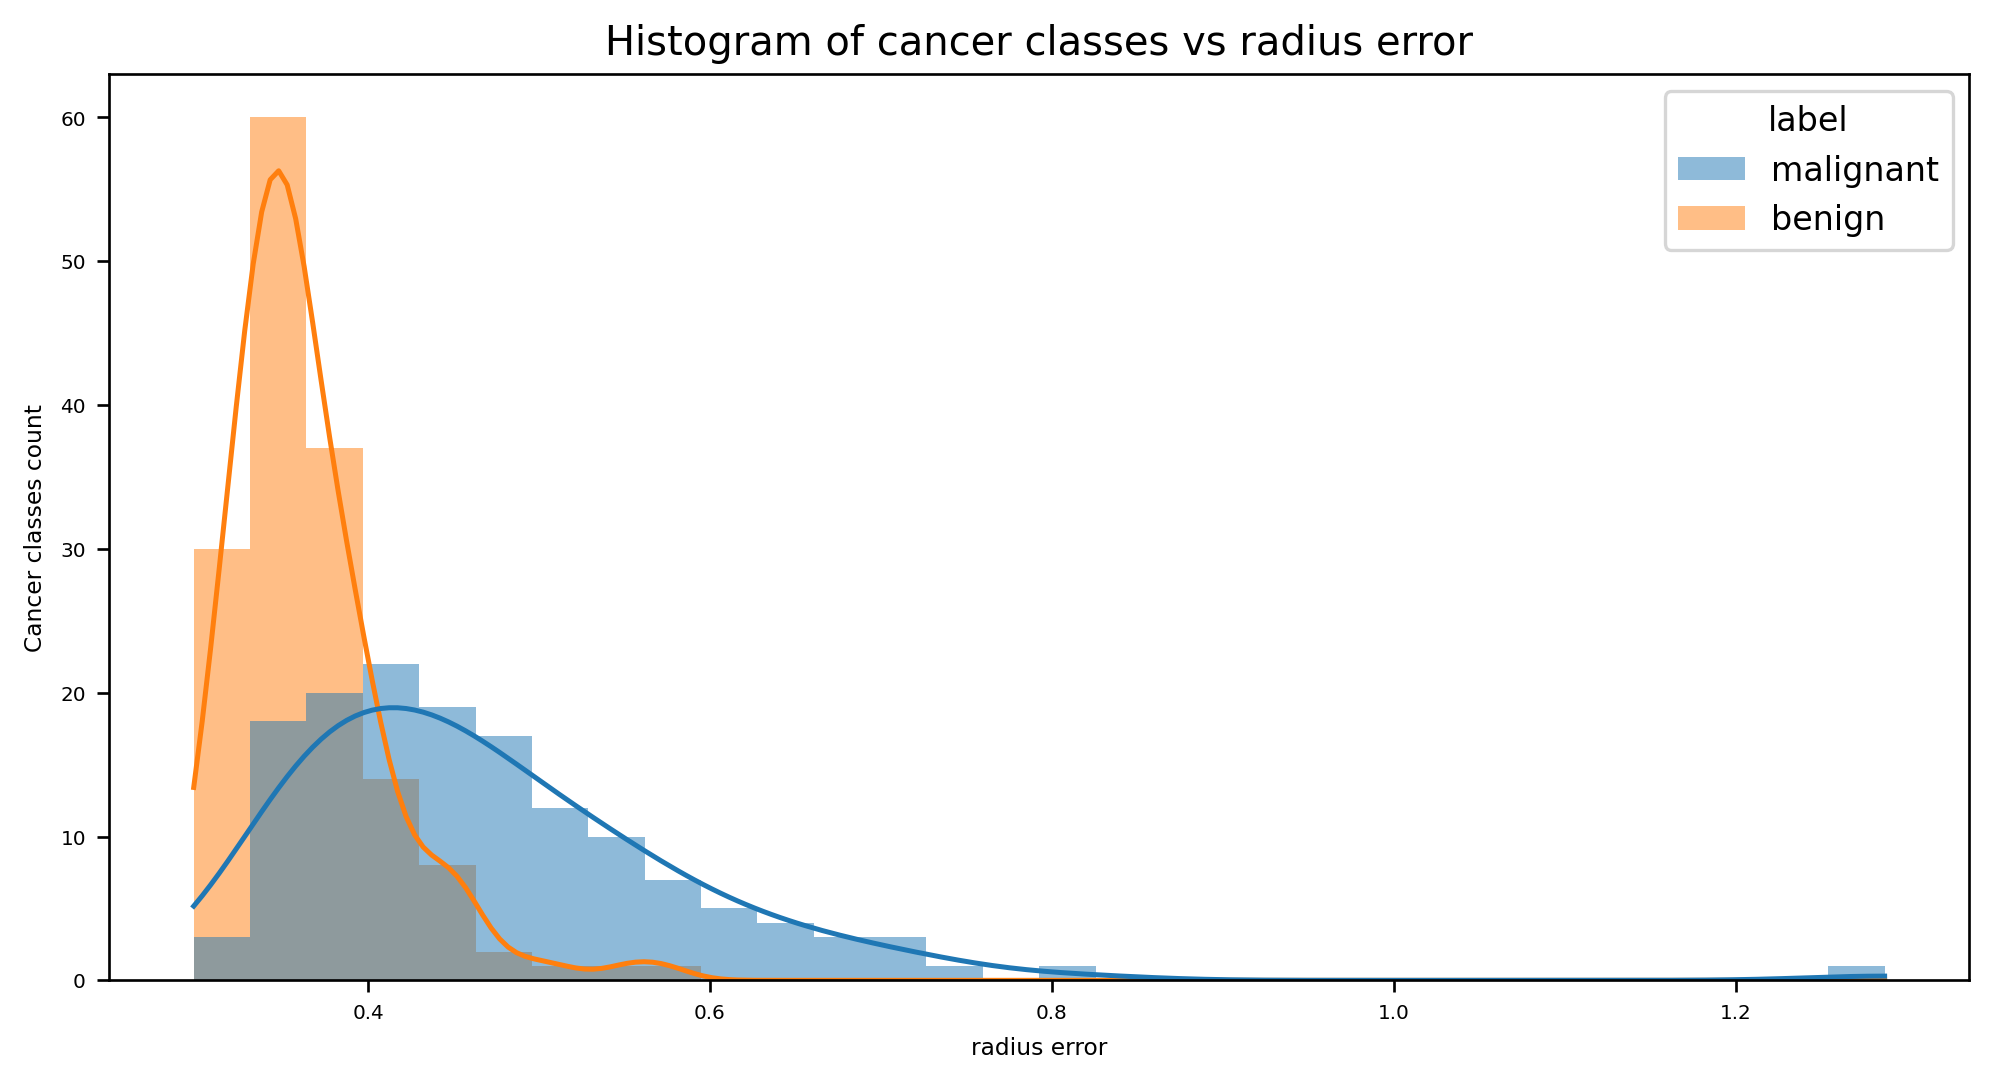

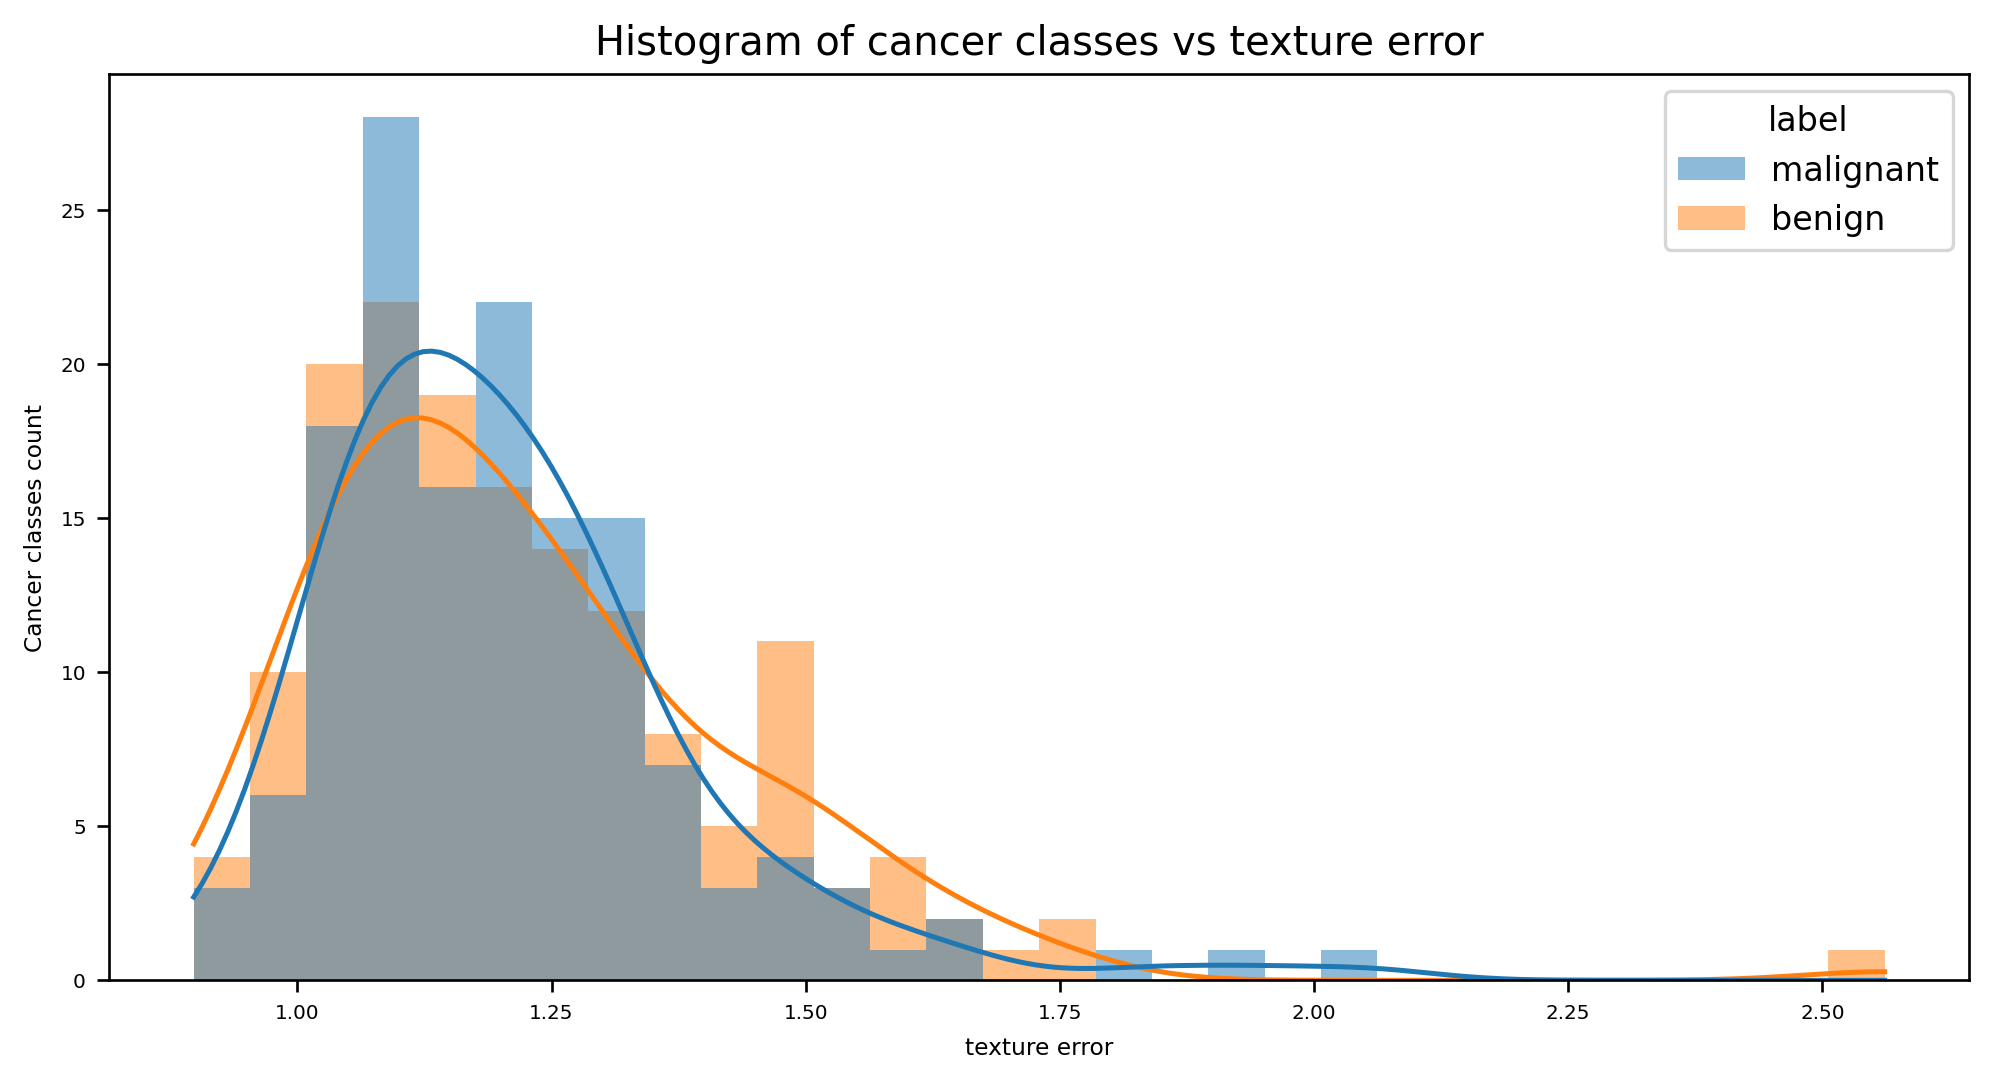

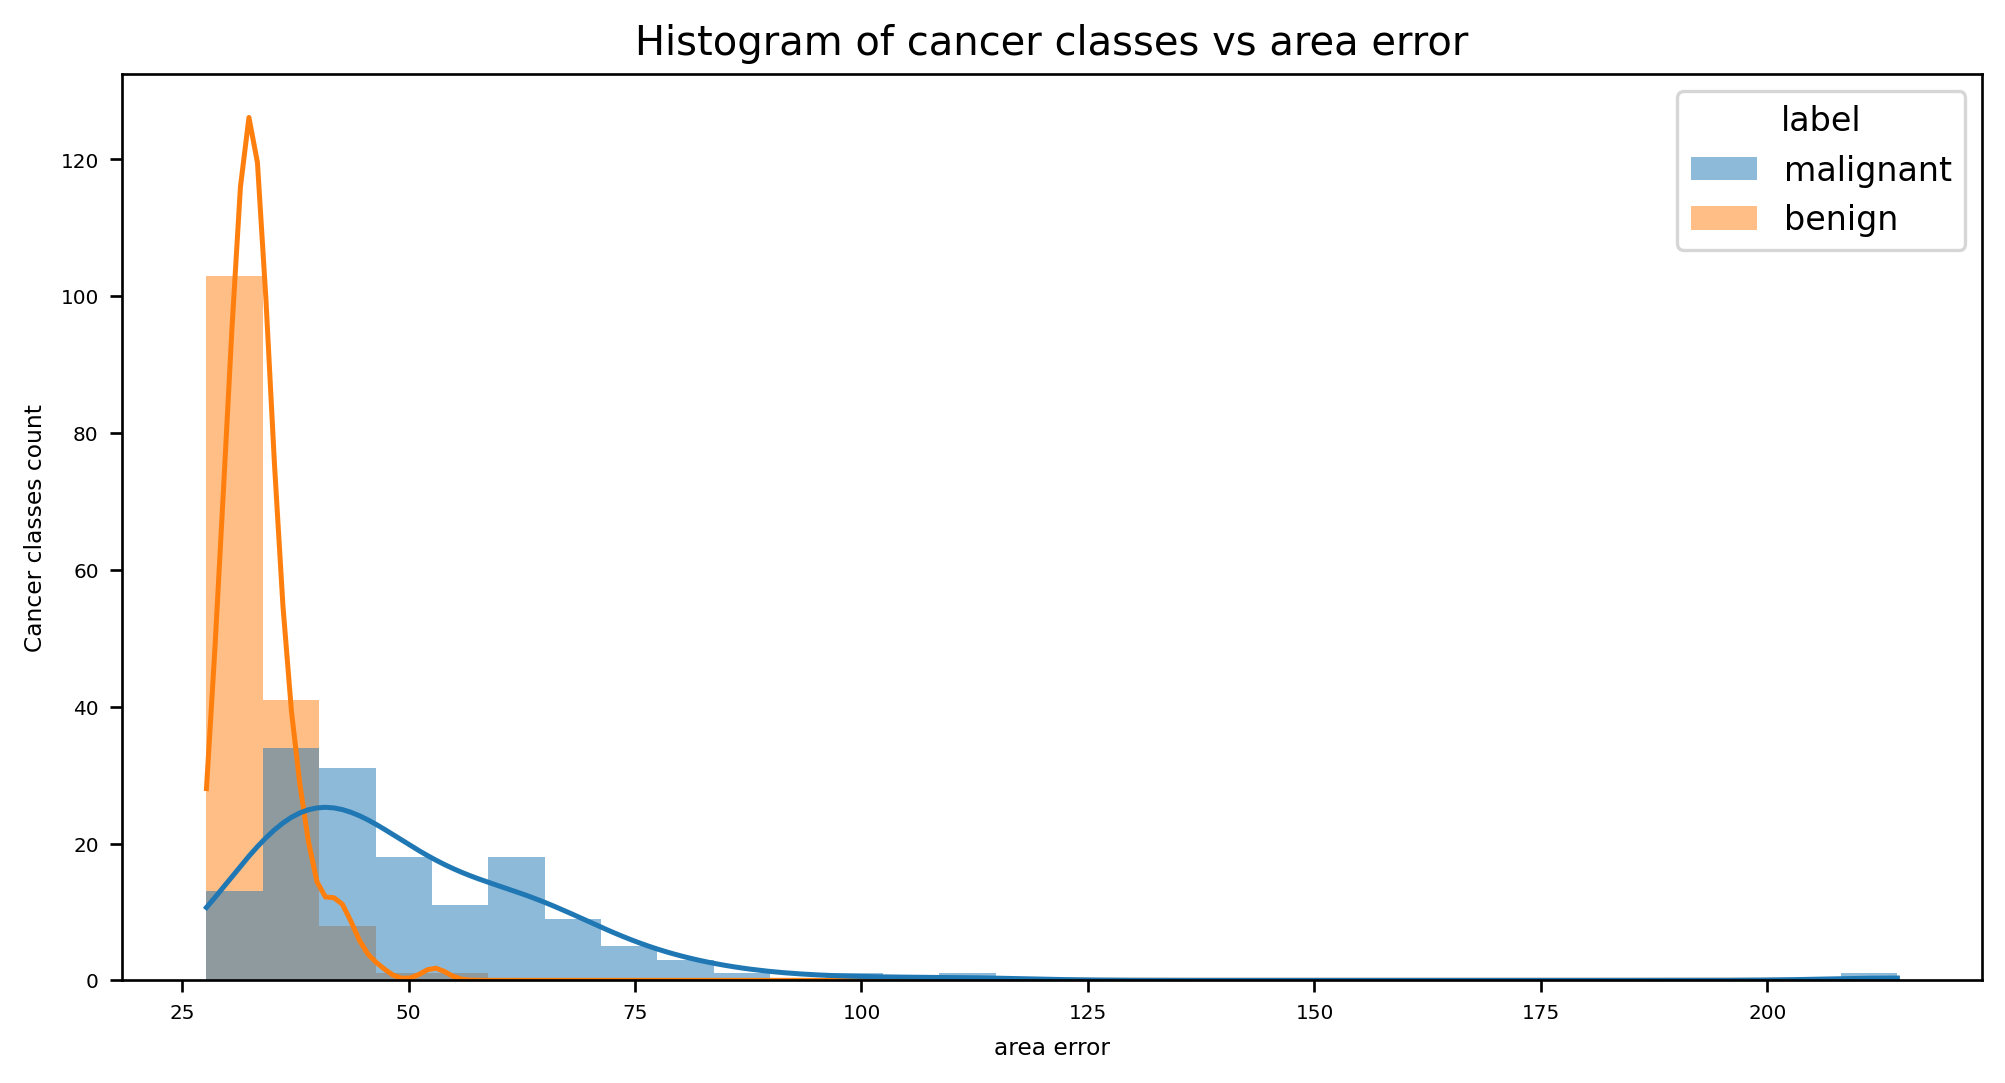

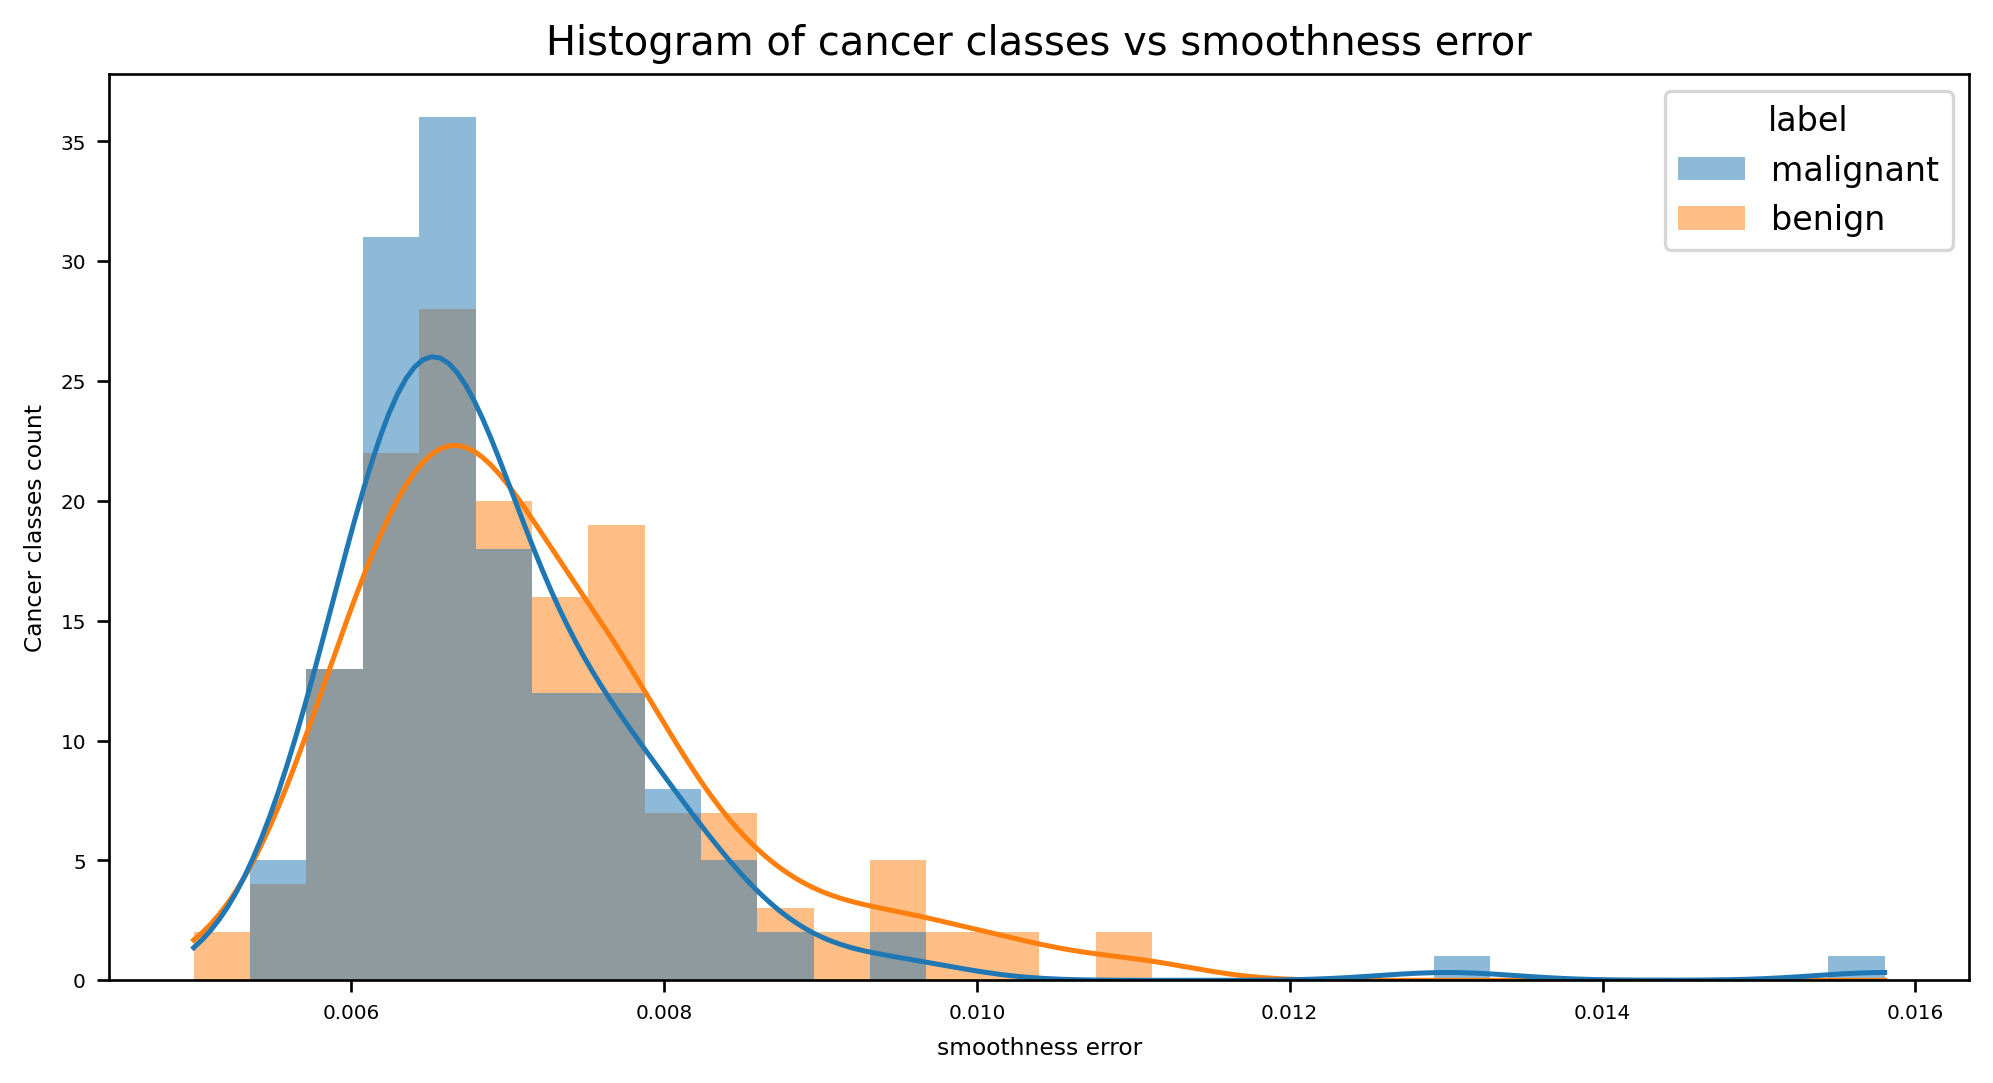

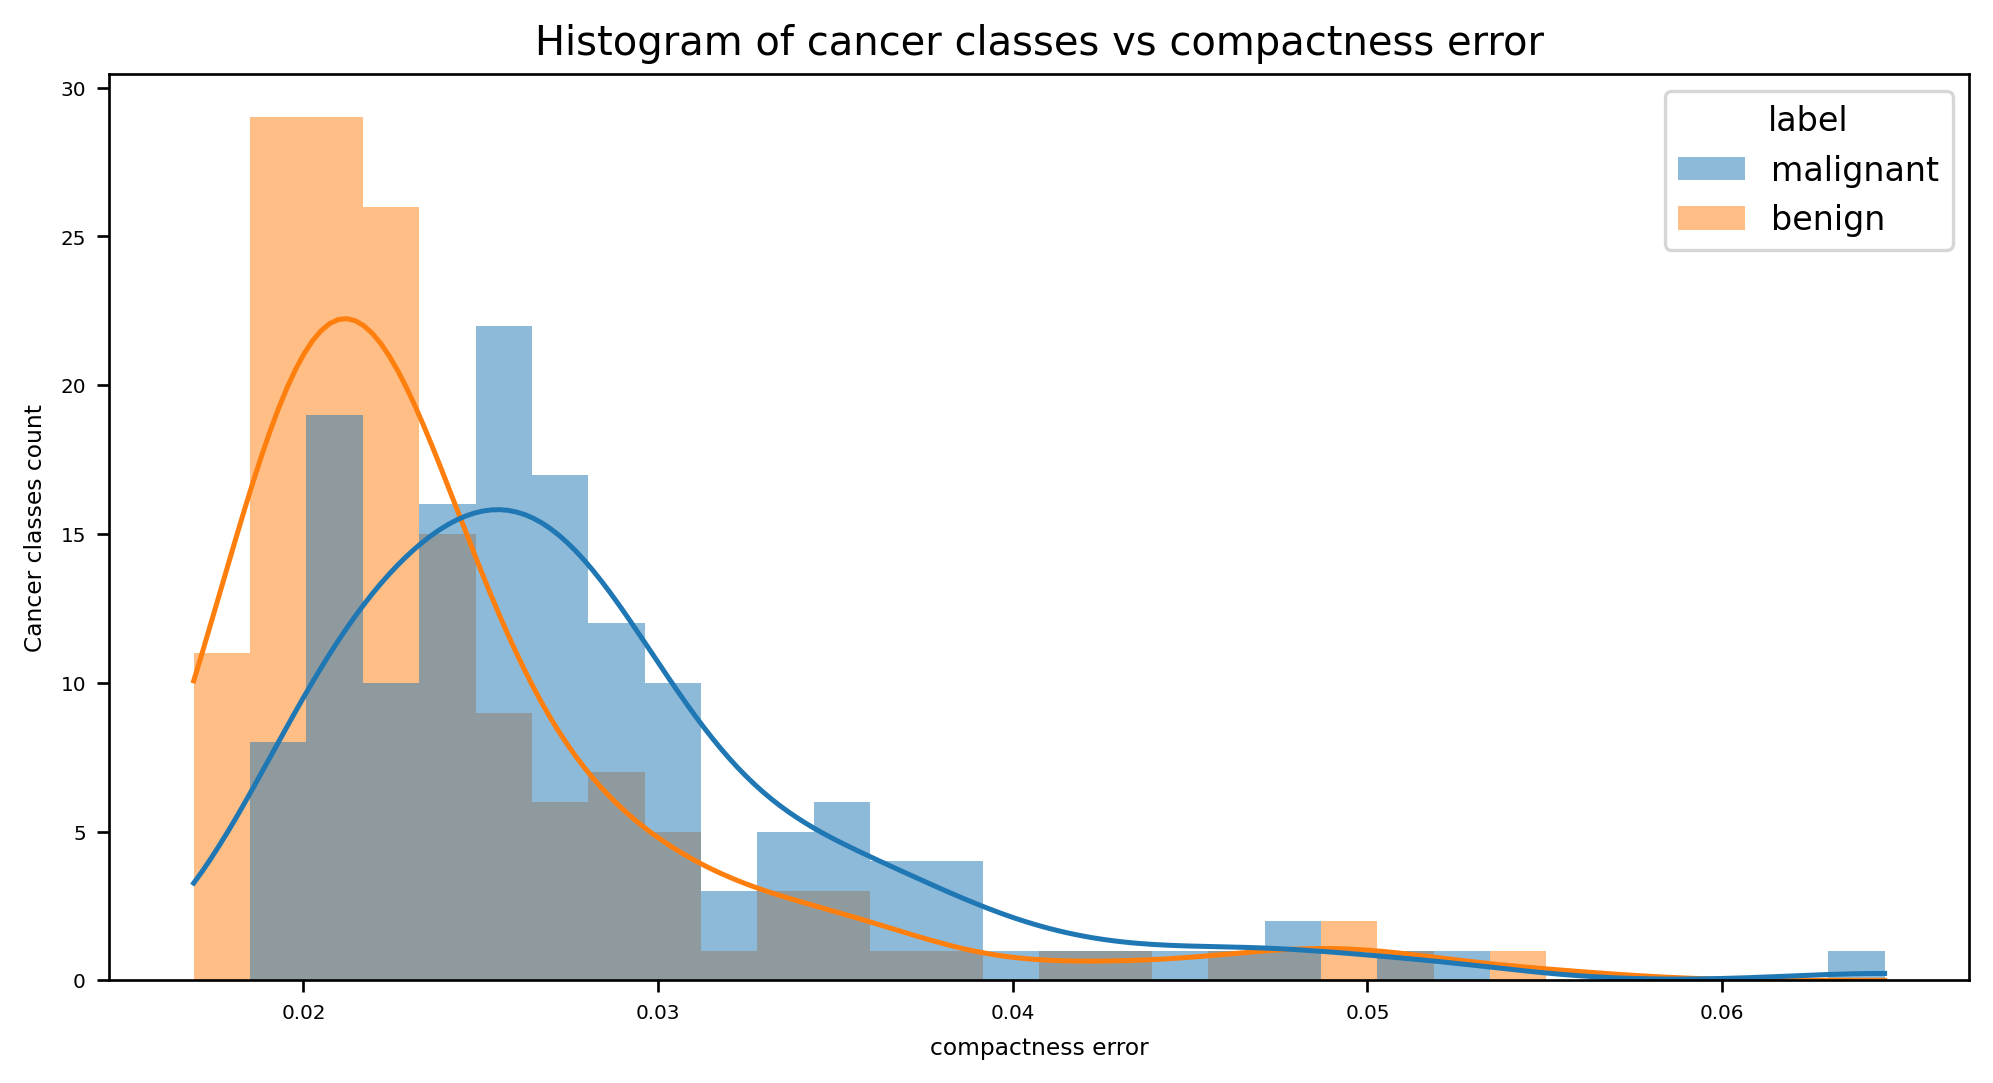

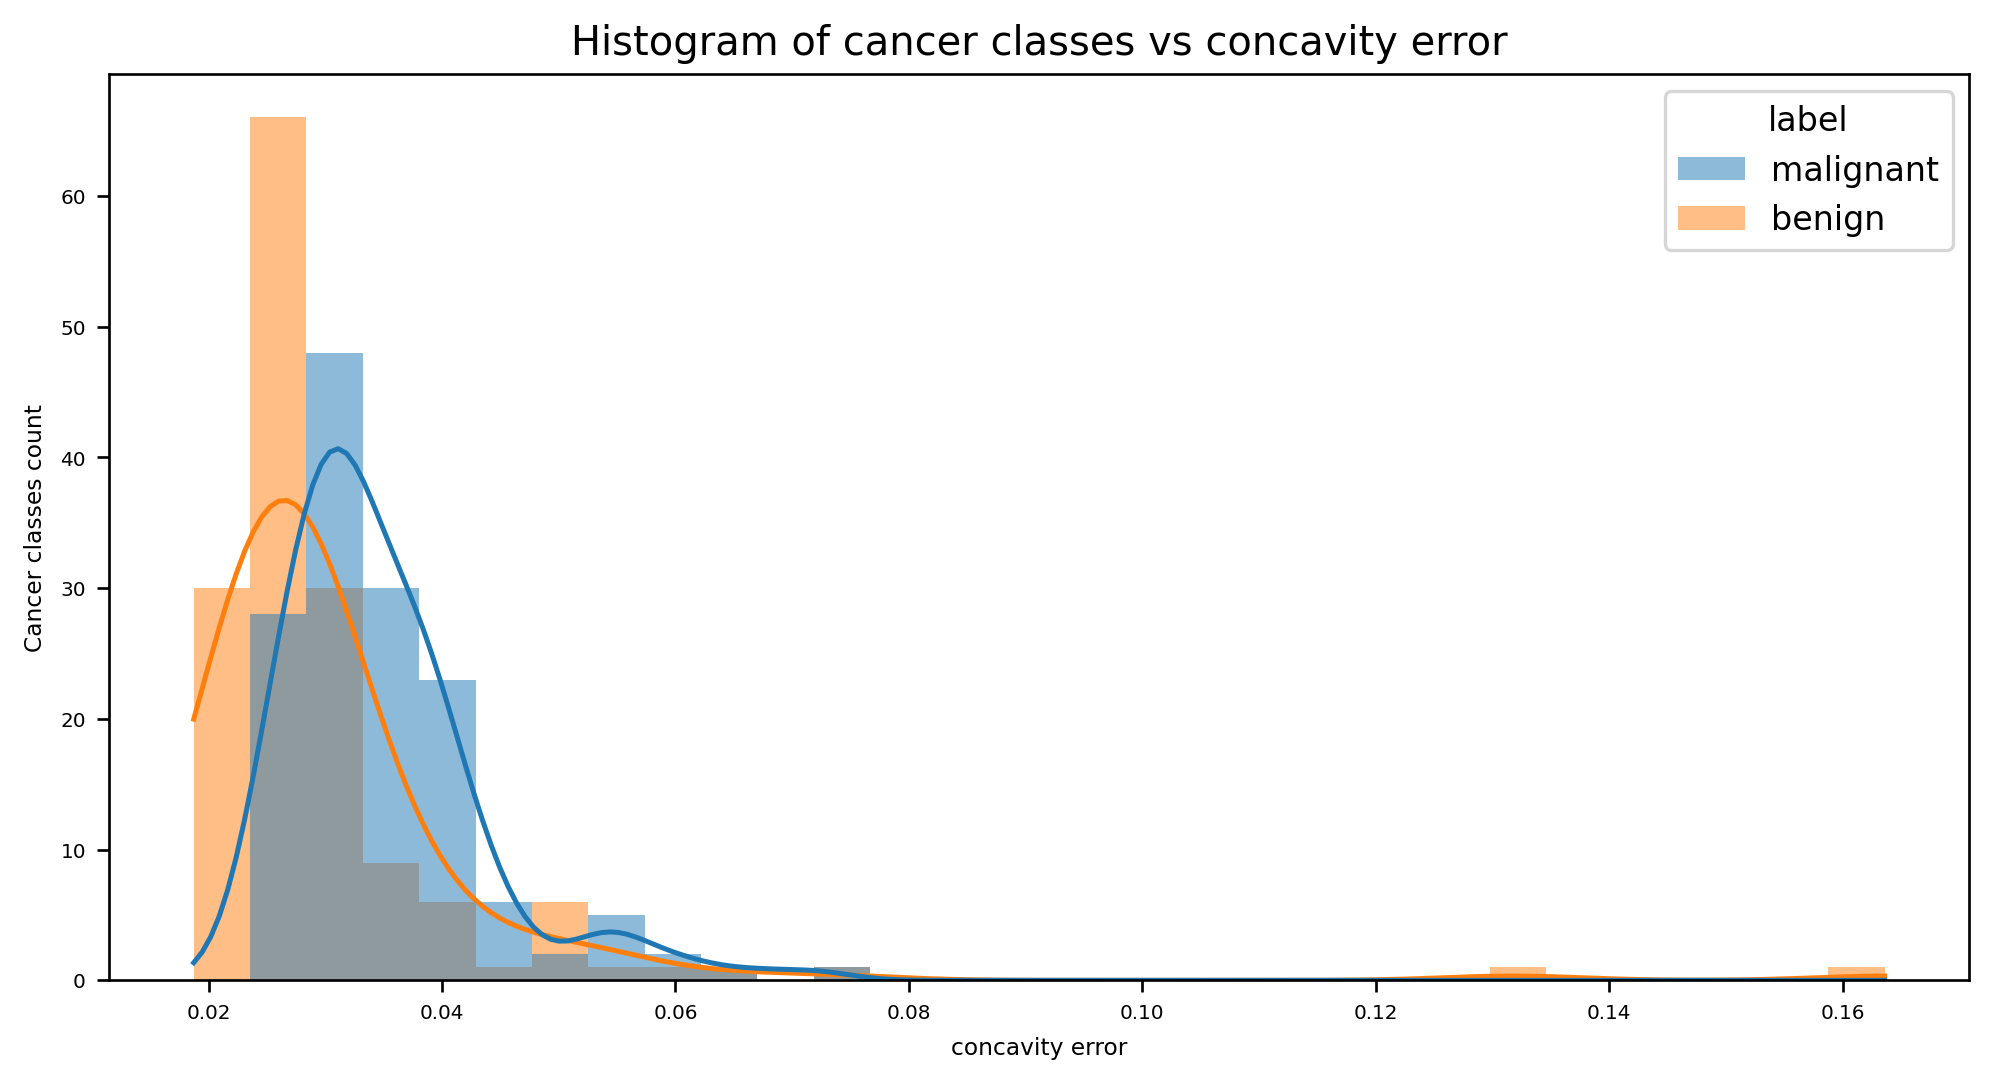

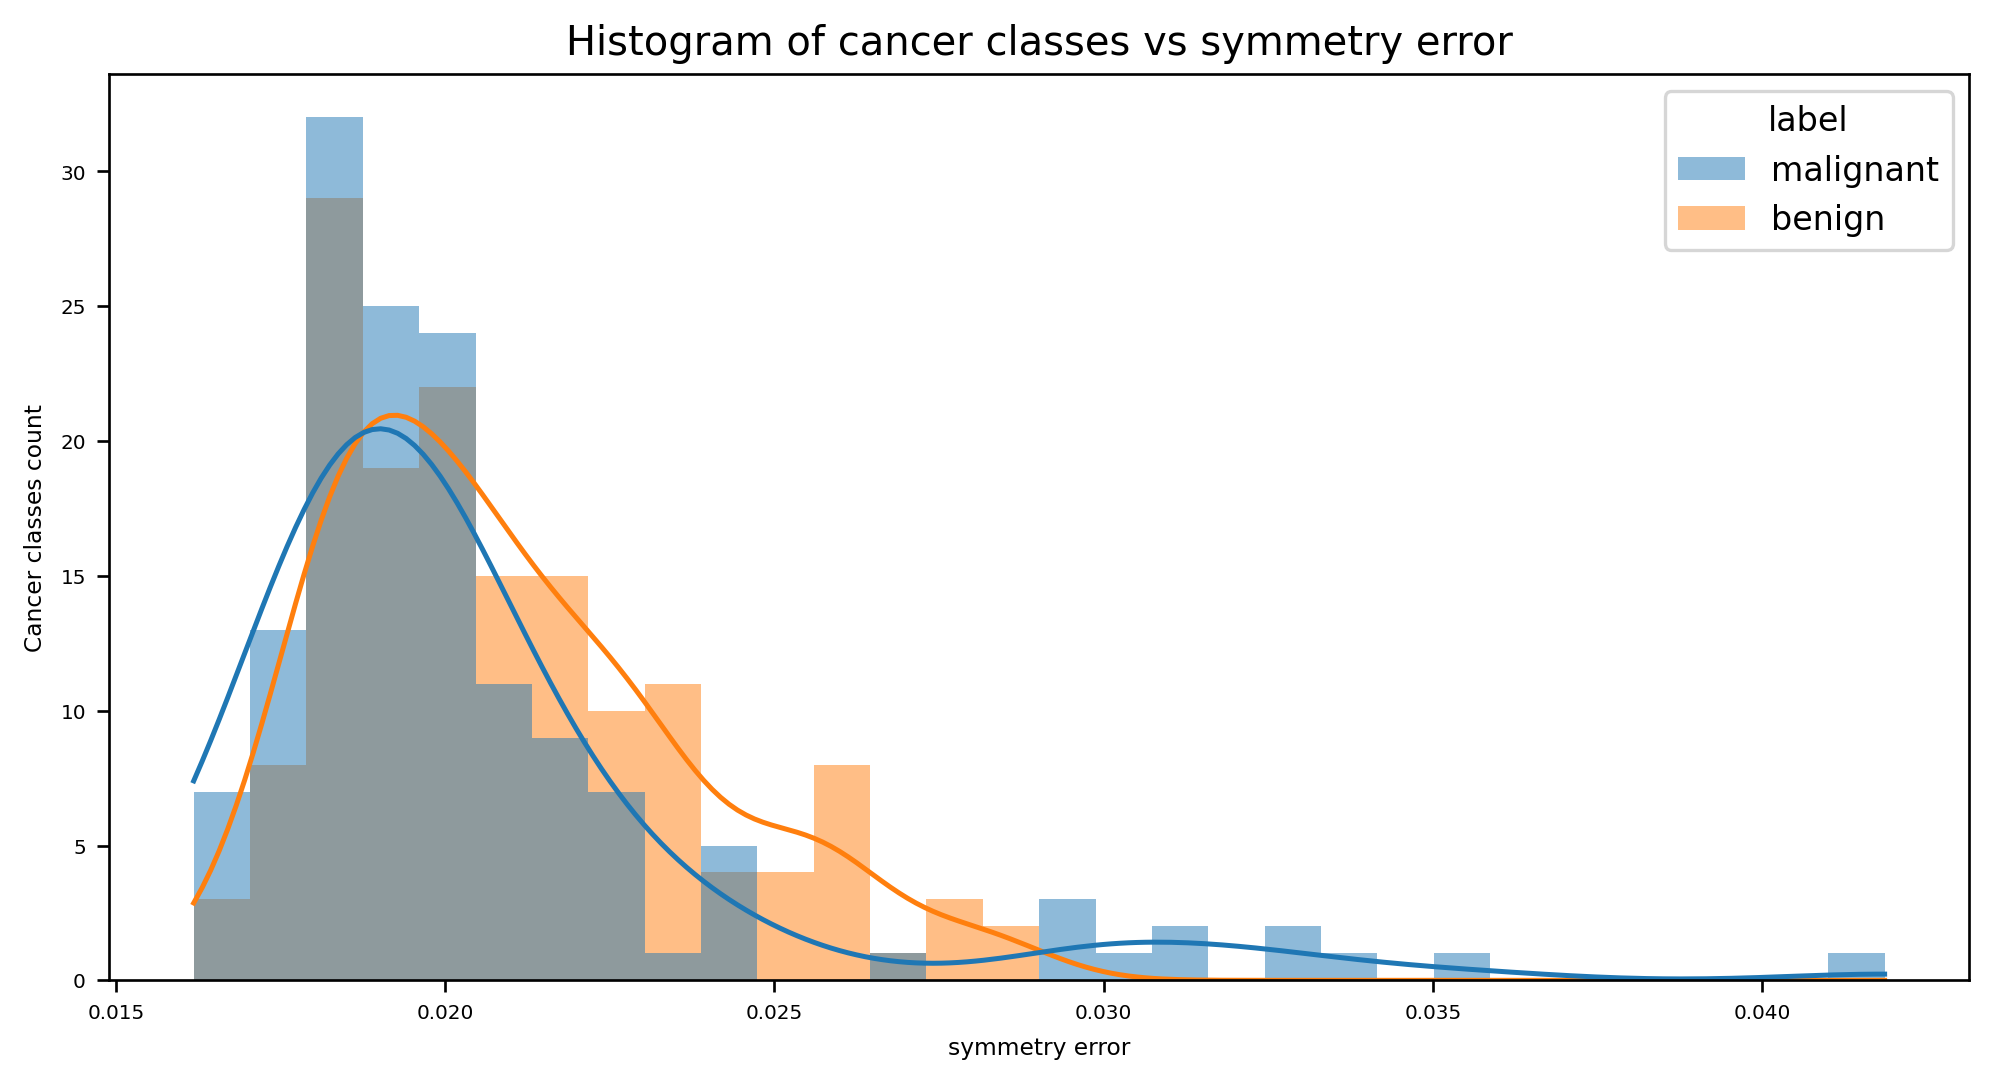

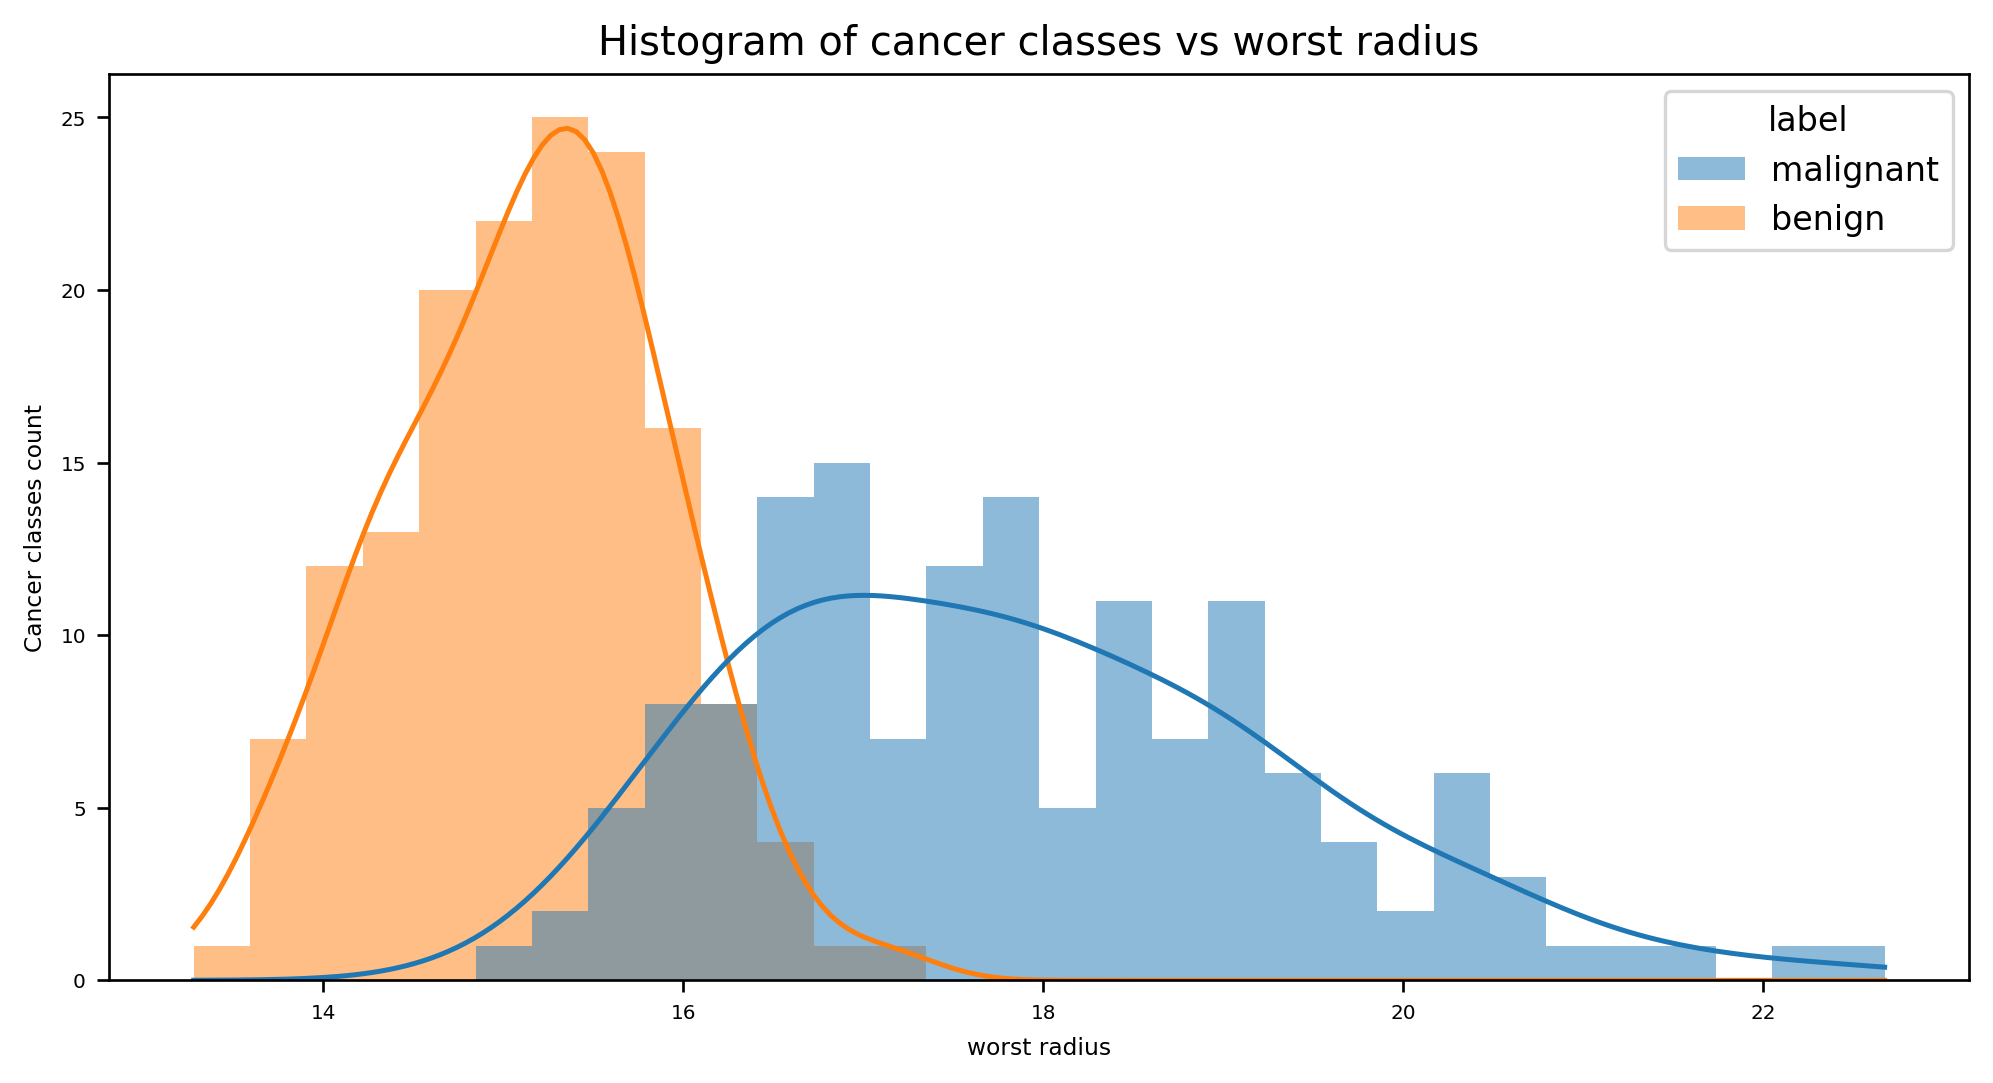

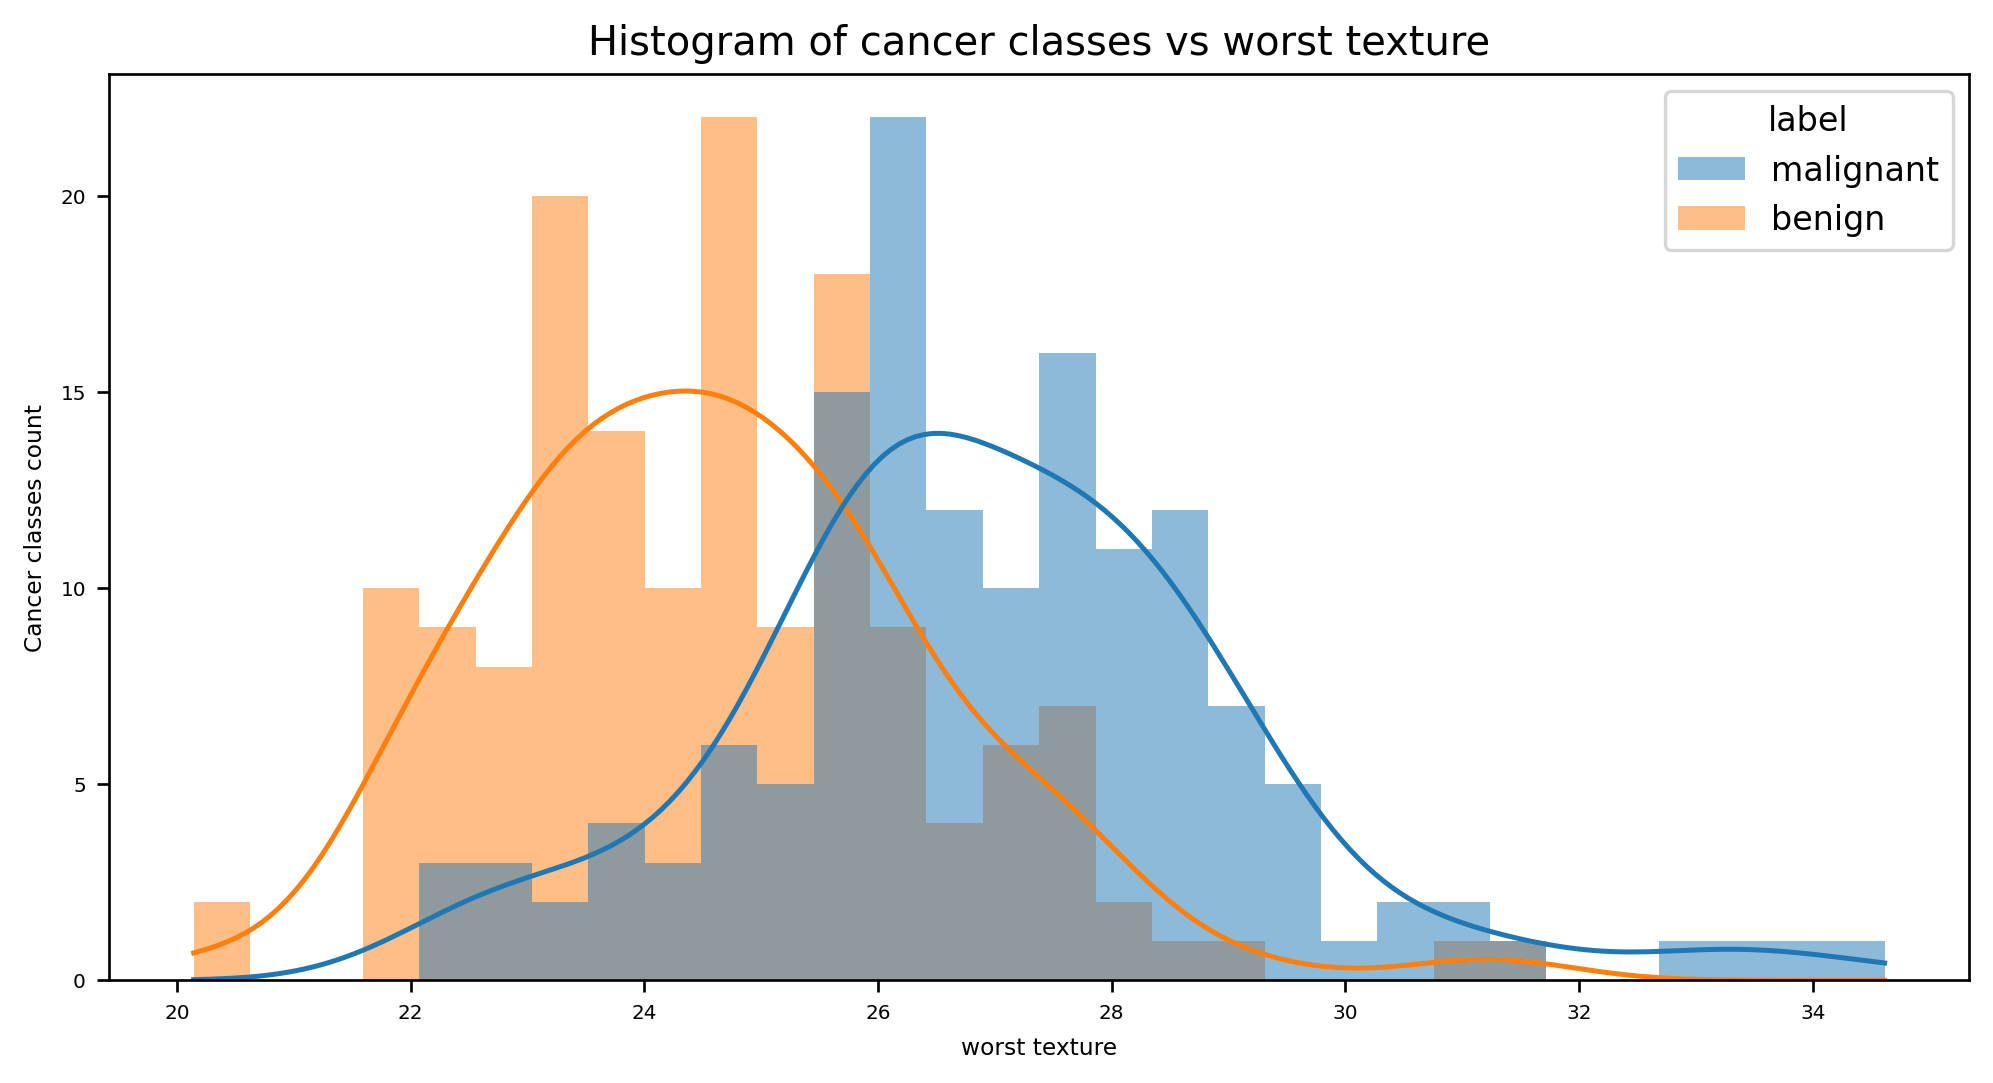

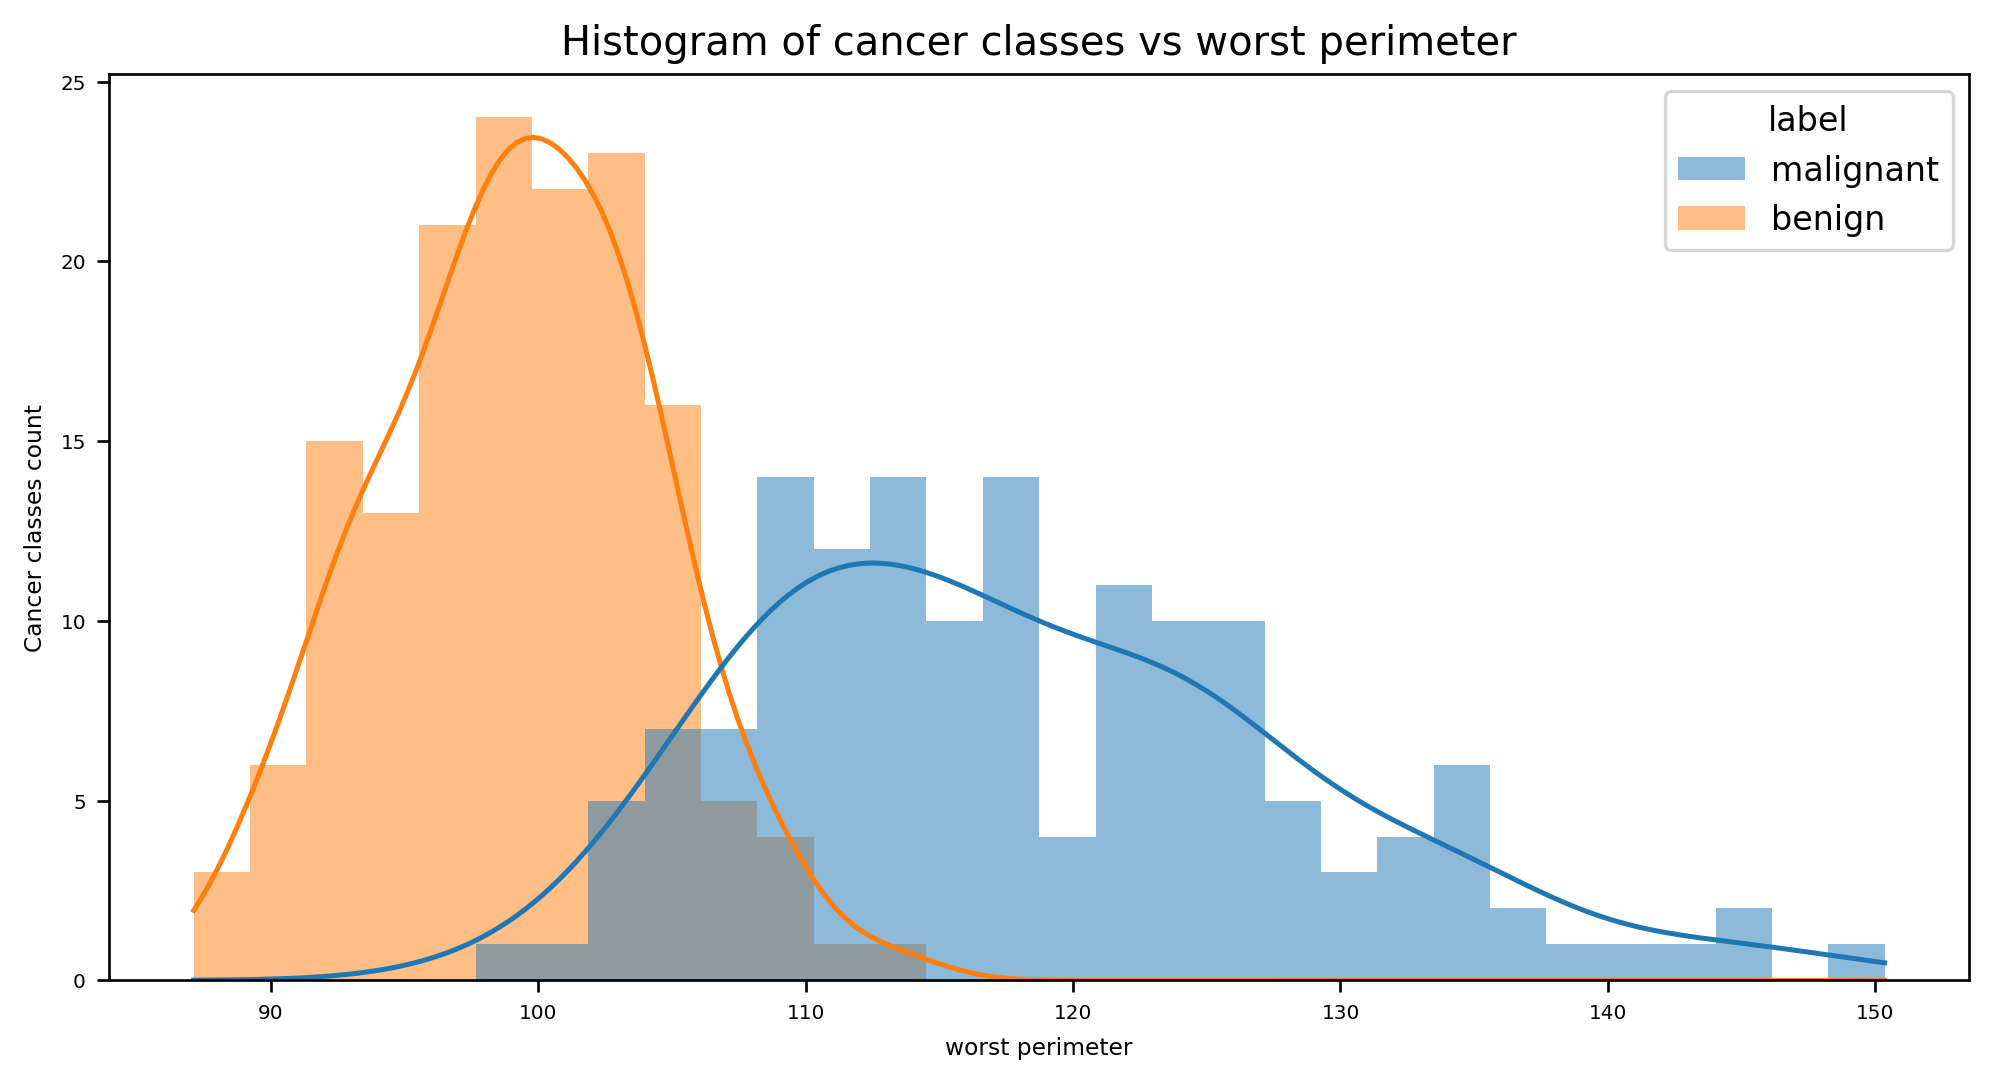

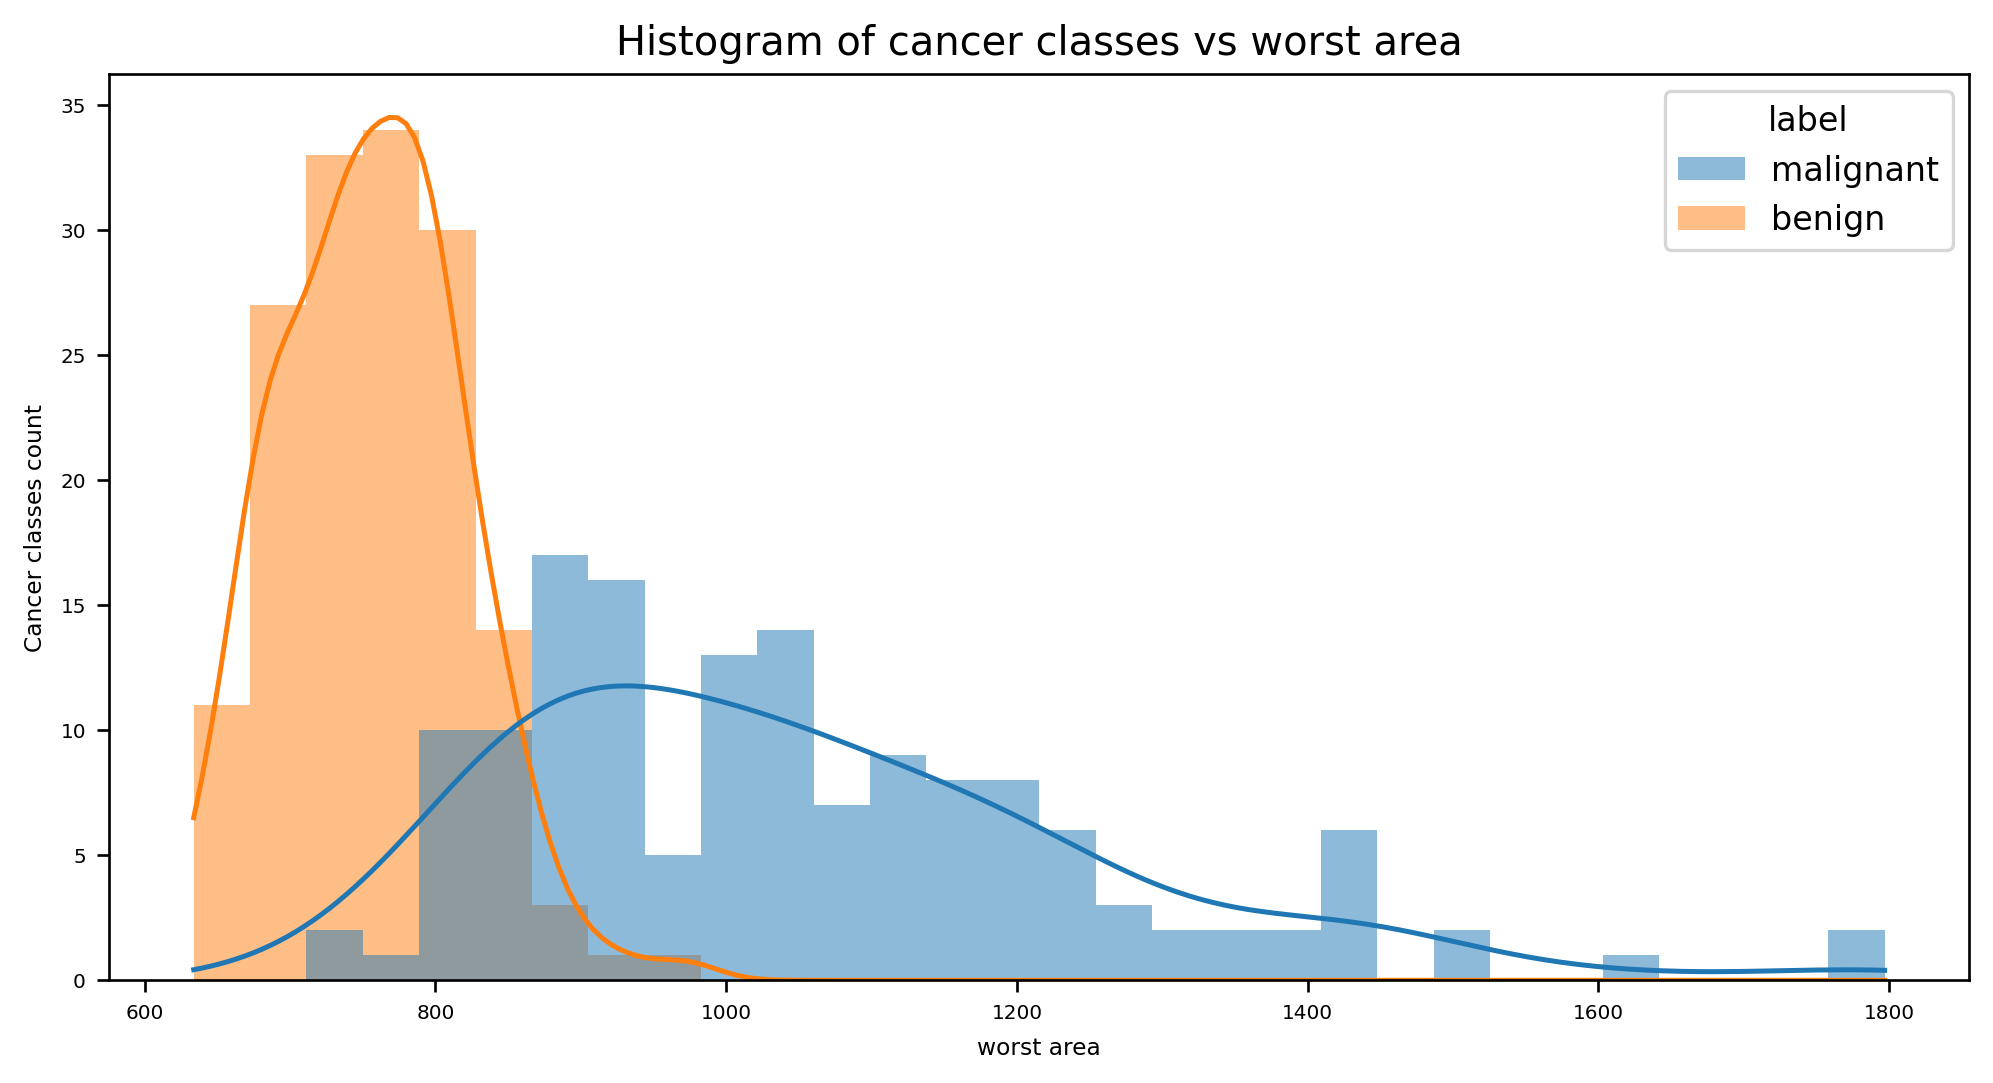

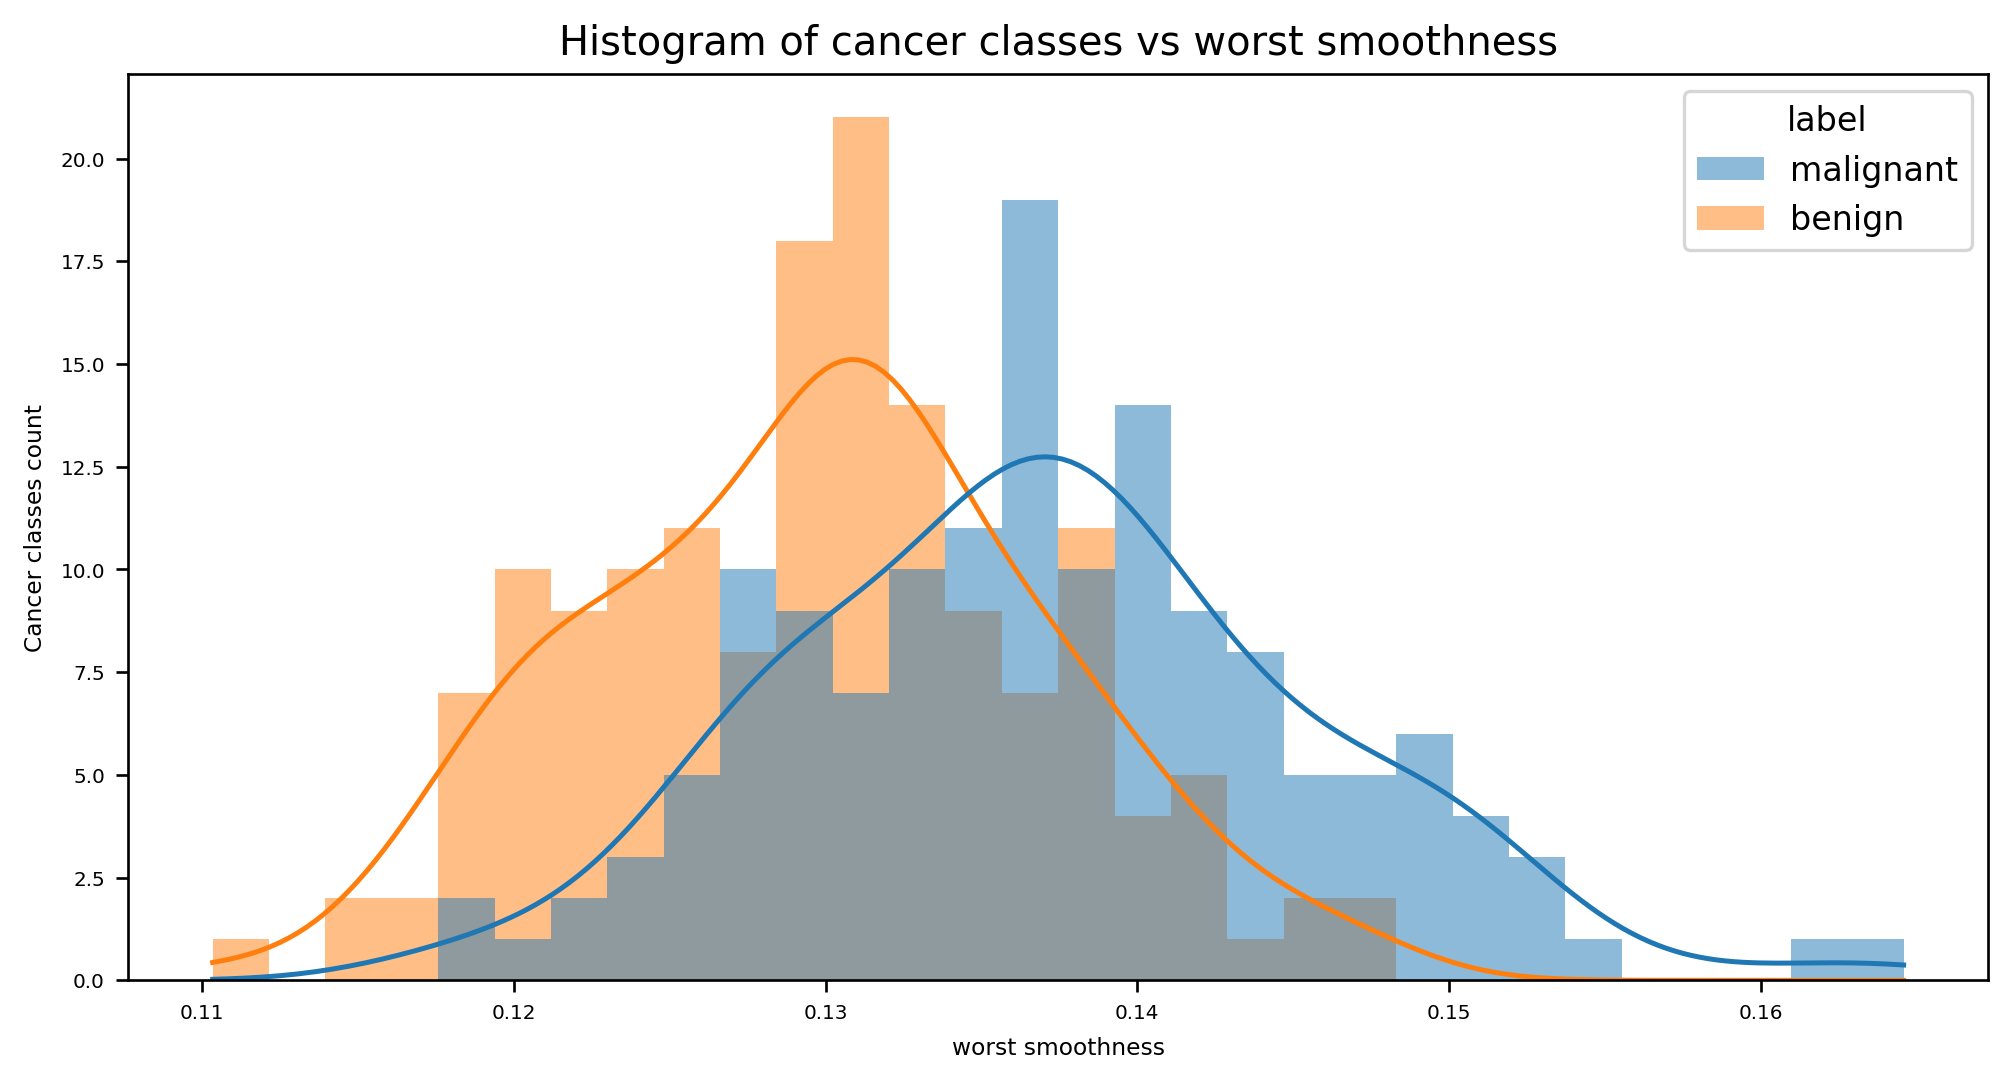

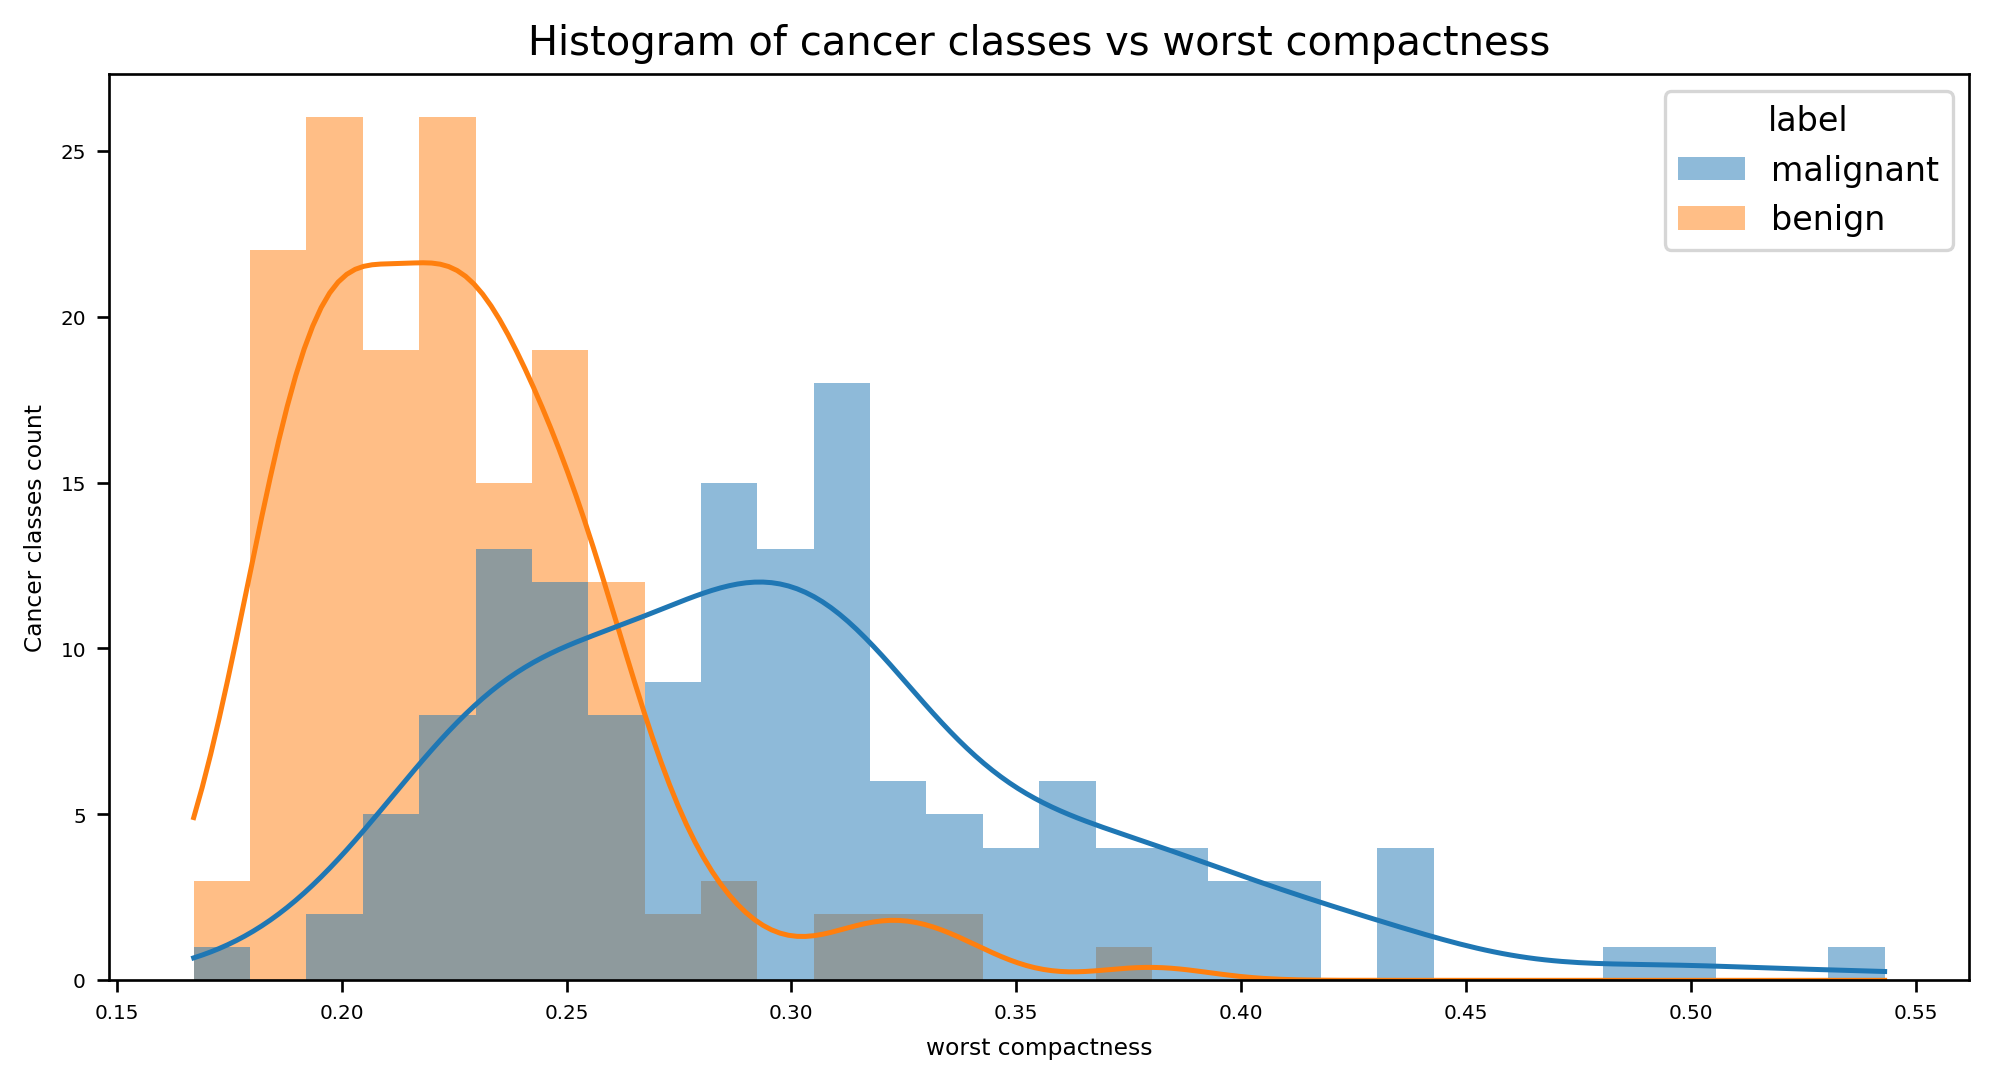

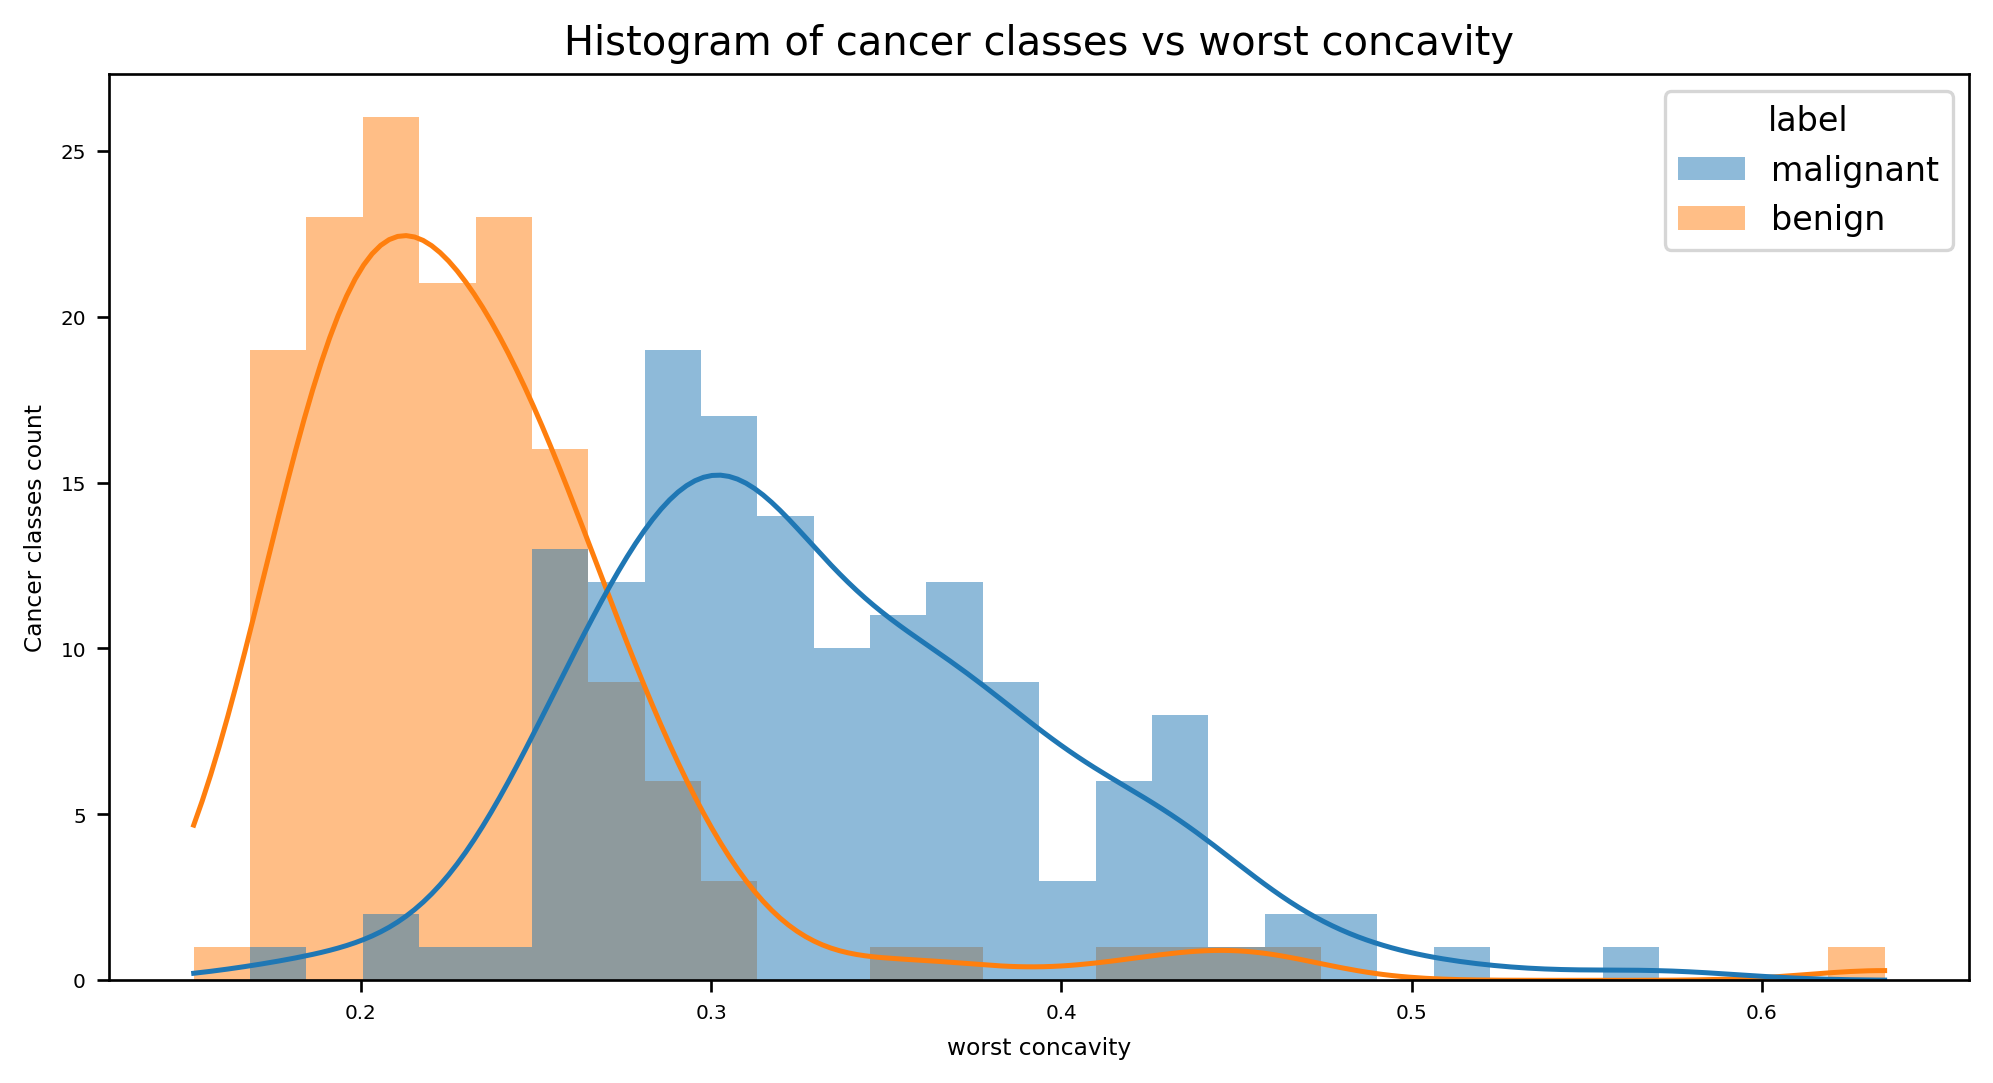

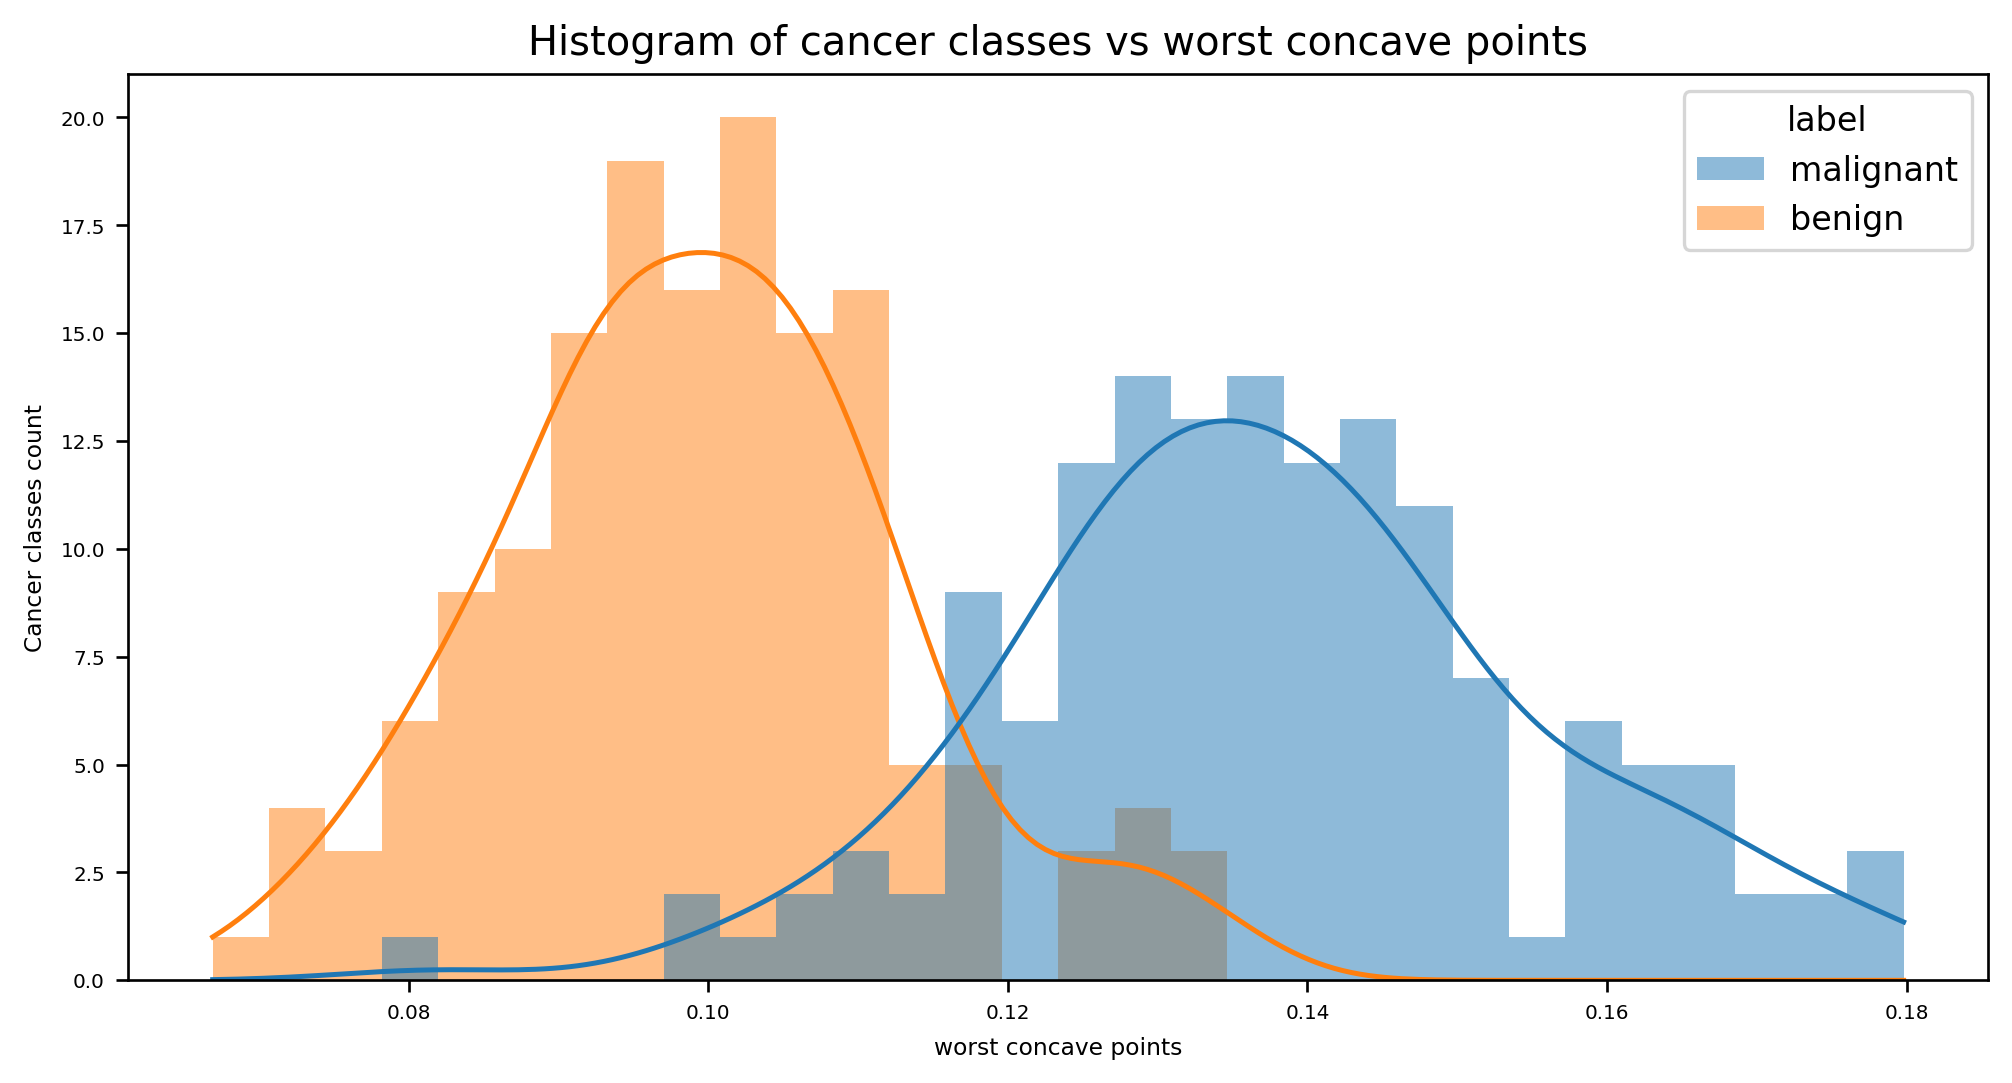

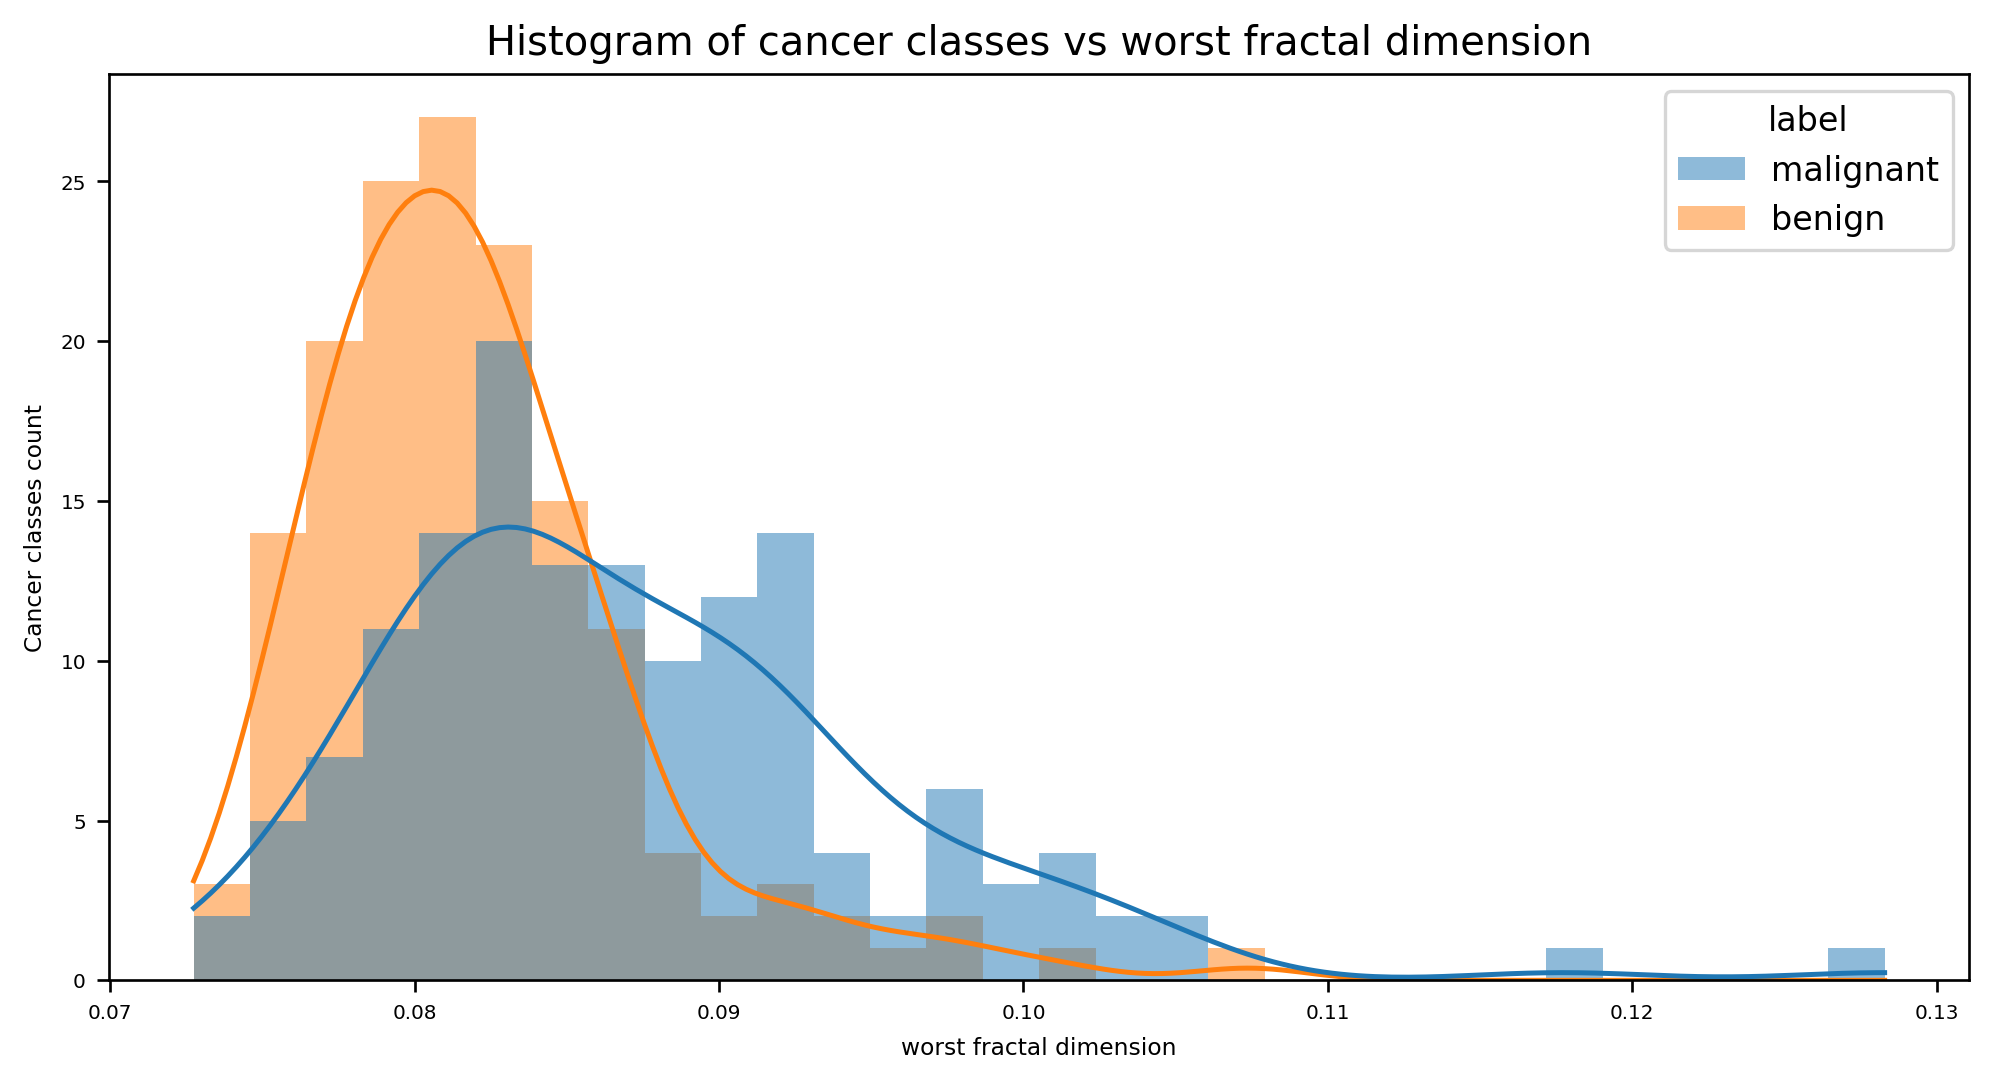

In [6]:
features = list(filter(lambda col: col != 'label', cancer.columns))
for i in features:
    plt.figure(figsize=(10, 5))  # Adjust the values to your desired size
    plt.title(f"Histogram of cancer classes vs {i}")
    sns.histplot(data=cancer, x=i, hue="label", bins=30, kde=True, edgecolor=None)
    plt.xlabel(i)
    plt.ylabel("Cancer classes count")
    plt.show()

### 1.3 Ranking the features [0.5 marks]

**Based on the histograms, which do you think are the 3 strongest features for discriminating between the classes?**

#### Your answer here
- worst concave points
- worst perimeter 
- worst radius

The reasons to choose those above because:
1. the peak of the two distribution are far apart which easier to classify
2. the overlap area between distributions are small.

### 1.4 Splitting the dataset [0.5 marks]

Split the dataset into appropriate subsets. You must choose what the subsets are and how big they are. However, we want to make sure the proportion of the two classes is consistent across all datasets, so use the _stratify_ option, as used in workshops 5 and 6. Verify the size and label distribution in each dataset.

In [7]:
class_counts = cancer['label'].value_counts()
total_samples = len(cancer)

proportions = class_counts / total_samples
print(proportions)

benign       0.513333
malignant    0.486667
Name: label, dtype: float64


In [8]:
# Tranform the target variable to 1 (malignant) and 0 (benign)
cancer['label'] = cancer['label'].map({'malignant':1,'benign':0})

In [9]:
cancer = cancer[['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension','label']]

# change the data to numpy array
cancer_array = cancer.values

In [10]:
# Your code here
from sklearn.model_selection import train_test_split

bigtrain_set, test_set = train_test_split(cancer_array, test_size=0.2, random_state=101, stratify=cancer_array[:,-1])
train_set, val_set = train_test_split(bigtrain_set, test_size=0.25, random_state=101, stratify=bigtrain_set[:,-1])

In [11]:
#Get the X and y for train, val and test
X_train = train_set[:,:-1]
y_train = train_set[:,-1]
X_test = test_set[:,:-1]
y_test = test_set[:,-1]
X_val = val_set[:,:-1]
y_val = val_set[:,-1]
print(f'Shapes are {[X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape]}')

Shapes are [(180, 30), (180,), (60, 30), (60,), (60, 30), (60,)]


In [12]:
# You can see the proportion of the classes in each partition
print(np.mean(y_train),np.mean(y_test),np.mean(y_val))

0.4888888888888889 0.48333333333333334 0.48333333333333334


## 2. Build, Train and Optimise Classifiers (60% = 18 marks)

### 2.1 Pipeline [0.5 marks]
**Build a pre-processing pipeline** that includes imputation (as even though we don't strictly need it here it is a good habit to always include it) and other appropriate pre-processing.  

In [13]:
# Your code here
from sklearn.impute import SimpleImputer

pre_pipeline = Pipeline([
("impute", SimpleImputer(strategy="median")),
("standardize",StandardScaler())])

### 2.2 Baseline measurements [1.5 marks]

For our classification task we will consider **three simple baseline cases**:
1) predicting all samples to be negative (class 1)
2) predicting all samples to be positive (class 2)
3) making a random prediction for each sample with equal probability for each class

**For each case measure and display the following metrics:**
 - balanced accuracy
 - recall
 - precision
 - auc
 - f1score
 - fbeta_score with beta=0.1
 - fbeta_score with beta=10

Code is given below for the latter metrics (all metrics are discussed in lecture 4 and many are in workshop 4).

Also **calculate and display the confusion matrix** for each baseline case, using a heatmap and numbers (as in workshop 4). 

In [14]:
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix

f10_scorer = make_scorer(fbeta_score, beta=10)
f01_scorer = make_scorer(fbeta_score, beta=0.1)

def f10_score(yt,yp):
    return fbeta_score(yt, yp, beta=10)

def f01_score(yt,yp):
    return fbeta_score(yt, yp, beta=0.1)

Case 1 - Predicting all samples as negative (class 1):
Balanced Accuracy: 0.5
Recall: 0.0
Precision: 0.0
AUC: 0.5
F1 Score: 0.0
F-beta Score (beta=0.1): 0.0
F-beta Score (beta=10): 0.0


C:\Users\PUTRI KHALILAH\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


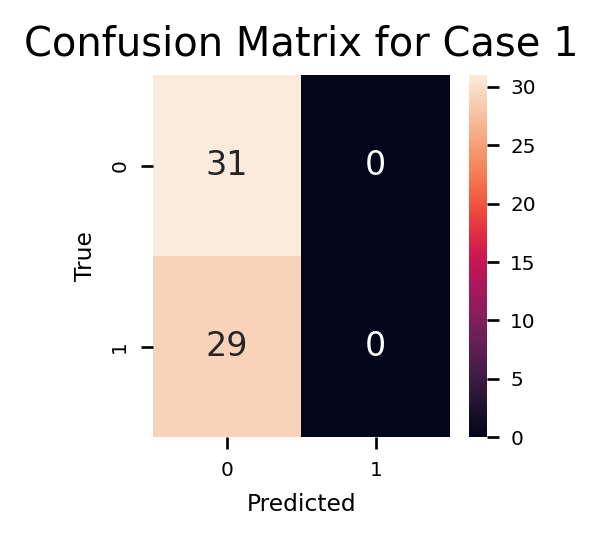

In [15]:
# Your code here


# Case 1 - predicting all samples to be negative
predictions_case1 = np.zeros(len(y_val))
metrics_case1 = {
    'Balanced Accuracy': metrics.balanced_accuracy_score(y_val, predictions_case1),
    'Recall': metrics.recall_score(y_val, predictions_case1),
    'Precision': metrics.precision_score(y_val, predictions_case1),
    'AUC': metrics.roc_auc_score(y_val, predictions_case1),
    'F1 Score': metrics.f1_score(y_val, predictions_case1),
    'F-beta Score (beta=0.1)': f01_score(y_val,predictions_case1),
    'F-beta Score (beta=10)': f10_score(y_val, predictions_case1)
}

print("Case 1 - Predicting all samples as negative (class 1):")
for metric, value in metrics_case1.items():
    print(f"{metric}: {value}")
    
cmat = confusion_matrix(y_true=y_val, y_pred=predictions_case1)
plt.figure(figsize=(2,2))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Case 1')
plt.show()

Case 1 - Predicting all samples as positive (class 2):
Balanced Accuracy: 0.5
Recall: 1.0
Precision: 0.48333333333333334
AUC: 0.5
F1 Score: 0.6516853932584269
F-beta Score (beta=0.1): 0.4858185437054239
F-beta Score (beta=10): 0.989527027027027


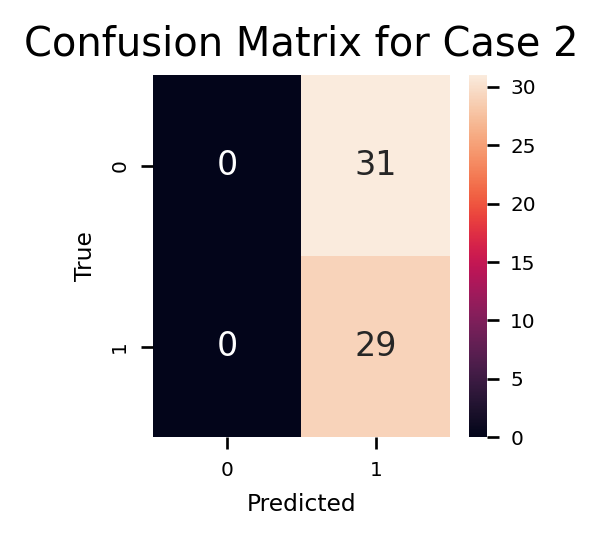

In [16]:
# Case 2 - predicting all samples to be positive
predictions_case2 = np.ones(len(y_val))
metrics_case2 = {
    'Balanced Accuracy': metrics.balanced_accuracy_score(y_val, predictions_case2),
    'Recall': metrics.recall_score(y_val, predictions_case2),
    'Precision': metrics.precision_score(y_val, predictions_case2),
    'AUC': metrics.roc_auc_score(y_val, predictions_case2),
    'F1 Score': metrics.f1_score(y_val, predictions_case2),
    'F-beta Score (beta=0.1)': f01_score(y_val, predictions_case2),
    'F-beta Score (beta=10)': f10_score(y_val, predictions_case2)
}

print("Case 1 - Predicting all samples as positive (class 2):")
for metric, value in metrics_case2.items():
    print(f"{metric}: {value}")
    
cmat = confusion_matrix(y_true=y_val, y_pred=predictions_case2)
plt.figure(figsize=(2,2))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Case 2')
plt.show()

In [17]:
# Case 3 - predicting all samples to be positive

from sklearn import metrics
np.random.seed(101)
predictions_case3 = np.random.randint(2, size=len(y_val))
metrics_case3 = {
    'Balanced Accuracy': metrics.balanced_accuracy_score(y_val, predictions_case3),
    'Recall': metrics.recall_score(y_val, predictions_case3),
    'Precision': metrics.precision_score(y_val, predictions_case3),
    'AUC': metrics.roc_auc_score(y_val, predictions_case3),
    'F1 Score': metrics.f1_score(y_val, predictions_case3),
    'F-beta Score (beta=0.1)': f01_score(y_val, predictions_case3),
    'F-beta Score (beta=10)': f10_score(y_val, predictions_case3)
}

print("Case 3 - making a random prediction for each sample with equal probability for each class:")
for metric, value in metrics_case3.items():
    print(f"{metric}: {value}")
    
cmat = confusion_matrix(y_true=y_val, y_pred=predictions_case3)
plt.figure(figsize=(2,2))
sns.heatmap(cmat,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Case 3')
plt.show()

Case 3 - making a random prediction for each sample with equal probability for each class:
Balanced Accuracy: 0.585650723025584
Recall: 0.6551724137931034
Precision: 0.5588235294117647
AUC: 0.585650723025584
F1 Score: 0.6031746031746031
F-beta Score (beta=0.1): 0.5596383785360163
F-beta Score (beta=10): 0.6540558963871848


### 2.3 Choose a performance metric [0.5 marks]

Based on the above baseline tests and the client's requirements, **choose a performance metric** to use for evaluating/driving your machine learning methods.  **Give a reason for your choice.**

#### Your answer here

Predicting malignant presence is most concern with False Negative (FN) which is the model predicting the patient have no malignant but in truth, they do have malignant presence. This is because it could delay or prevent timely medical intervention and treatment for individuals who require it.

We also concern with False Positive (FP) which is the model predicting the patient have malignant but in truth, they do not have malignant presence. This case may cause anxiety to the patient but with additional tests, can solve the problem.

As per client's requirement, they wanted to have at least 95% probability of detecting malignant cancer when it is present. Hence, we need to minimize both FP and FN in detecting malignant presence.

 In this context,given the relevance:

* False negative (FN) is when you are predicting the tumor is benign, but actually is malignant
* False positive (FP) is when you are predicting the tumor is malignant, but actually is benign

FN cases could be much worse, so, for this case is more important avoid FN -- > recall

As for the second requirement, the client wants to have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant) meaning the Recall should be given more weigtage than Precision to the F1 score calculation.

Alas, I chose <b>F-beta Score (beta=10)</b> metric performance.

### 2.4 SGD baseline [1 mark]

For a stronger baseline, **train and evaluate** the Stochastic Gradient Descent classifier (as seen in workshop 5). For this baseline case use the default settings for all the hyperparameters.

In [18]:
# Your code here
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, hinge_loss
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# create the pipeline
sgd_classifier = Pipeline([
("pre_pipeline",pre_pipeline),
("sgd",SGDClassifier(max_iter=1000, tol=1e-3))])

# Set random seed for reproducibility
np.random.seed(101)

# Train the SGD on X_train dataset
sgd_classifier.fit(X_train,y_train)

# Evaluate on X_val
y_val_pred = sgd_classifier.predict(X_val)


# Measuring Accuracy Using Cross-Validation
metrics_sgd_baseline = {
    'Balanced Accuracy': metrics.balanced_accuracy_score(y_val, y_val_pred),
    'Recall': metrics.recall_score(y_val, y_val_pred),
    'Precision': metrics.precision_score(y_val, y_val_pred),
    'AUC': metrics.roc_auc_score(y_val, y_val_pred),
    'F1 Score': metrics.f1_score(y_val, y_val_pred),
    'F-beta Score (beta=0.1)': f01_score(y_val, y_val_pred),
    'F-beta Score (beta=10)': f10_score(y_val, y_val_pred)
}

print("SGD Baseline Performance metrics")
for metric, value in metrics_sgd_baseline.items():
    print(f"{metric}: {value}")

SGD Baseline Performance metrics
Balanced Accuracy: 0.9655172413793103
Recall: 0.9310344827586207
Precision: 1.0
AUC: 0.9655172413793103
F1 Score: 0.9642857142857143
F-beta Score (beta=0.1): 0.9992671308171491
F-beta Score (beta=10): 0.9316706525452682


### 2.5 Confusion matrix [1 mark]

Calculate and display the normalized version of the confusion matrix.  From this **calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.  Which of the client's two criteria does this relate to, and is this baseline satisfying this criterion or not?**

In [19]:
# Your code here
cmat_sgd_classifier = confusion_matrix(y_true=y_val, y_pred=y_val_pred,normalize="true")
sns.heatmap(cmat_sgd_classifier,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalize Confusion Matrix')
plt.show()

#### Your answer here
The probability is 0.14.

Recall metric is related for this probability.This means it looks at true positives and false negatives
(which are positives that have been incorrectly predicted as negative).

No, the baseline does not satisfy the criteria becuase the criteria want to have 95% of recall but the Recall is 0.93103 (93.10%)

### 2.6 Main classifier [11 marks]

**Train and optimise the hyperparameters** to give the best performance for **each of the following classifiers**:
 - KNN (K-Nearest Neighbour) classifier
 - Decision tree classifier
 - Support vector machine classifier
 - SGD classifier
 
Follow best practice as much as possible here. You must make all the choices and decisions yourself, and strike a balance between computation time and performance.

You can use any of the sci-kit learn functions in sklearn.model_selection.cross* and anything used in workshops 3, 4, 5 and 6. Other hyper-parameter optimisation functions apart from these cannot be used (even if they are good and can be part of best practice in other situations - for this assignment everyone should assume they only have very limited computation resources and limit themselves to these functions).

**Display the performance of the different classifiers and the optimised hyperparameters.**

**Based on these results, list the best 3 classifiers and indicate if you think any perform equivalently.**

In [20]:
# Combine both X_train and X_val
# Set and train the model
big_train_X = np.concatenate((X_train, X_val), axis = 0)
big_train_y = np.concatenate((y_train, y_val), axis = 0)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

# Classifiers
knn_classifier = Pipeline([
("pre_pipeline",pre_pipeline),
("knn_classifier",KNeighborsClassifier())])

dt_classifier = Pipeline([
("pre_pipeline",pre_pipeline),
("dt_classifier",DecisionTreeClassifier(random_state=101))])

svc_classifier = Pipeline([
("pre_pipeline",pre_pipeline),
("svc_classifier",SVC())])

# Set random seed for reproducibility
np.random.seed(101)
sgd_classifier = Pipeline([
("pre_pipeline",pre_pipeline),
("sgd_classifier",SGDClassifier())])

# Parameters
knn_parameters = {'knn_classifier__n_neighbors' : [3,7,5,9,11],
                  'knn_classifier__weights':['uniform','distance']}
dt_parameters = {'dt_classifier__criterion' : ['gini'], 'dt_classifier__splitter':['best'],
                 'dt_classifier__random_state':[101]}
svc_parameters = {'svc_classifier__C' : [1, 10, 100],
                  'svc_classifier__kernel':['linear', 'rbf','poly']}

# Set random seed for reproducibility
np.random.seed(101)
eta0 = [10.0 ** lr_exp for lr_exp in range(-8, 3)]    
learnrate = ['constant','optimal']
sgd_parameters = {'sgd_classifier__early_stopping':[True,False],
                  'sgd_classifier__eta0':eta0,'sgd_classifier__learning_rate':learnrate,'sgd_classifier__warm_start':[True,False]}


# Searching the best
knn_best = GridSearchCV(knn_classifier, knn_parameters,cv = 5, scoring= 'f1')
dt_best = GridSearchCV(dt_classifier, dt_parameters,cv = 5,scoring='f1')
svc_best = GridSearchCV(svc_classifier,svc_parameters, cv=5,scoring='f1')
sgd_best = GridSearchCV(sgd_classifier, sgd_parameters,cv=5,scoring='f1')

# fit with big_train
knn_best.fit(big_train_X, big_train_y)
dt_best.fit(big_train_X, big_train_y)
svc_best.fit(big_train_X, big_train_y)
sgd_best.fit(big_train_X, big_train_y)


# F1 score
print("KNN F1 score for training:",round(knn_best.best_score_,7),"with parameters",knn_best.best_params_)
print("DT F1 score for training:",round(dt_best.best_score_,7),"with parameters",dt_best.best_params_)
print("SVC F1 score for training:",round(svc_best.best_score_,7),"with parameters",svc_best.best_params_)
print("SGD F1 score for training:",round(sgd_best.best_score_,7),"with parameters",sgd_best.best_params_)


KNN F1 score for training: 0.9559886 with parameters {'knn_classifier__n_neighbors': 9, 'knn_classifier__weights': 'distance'}
DT F1 score for training: 0.9151441 with parameters {'dt_classifier__criterion': 'gini', 'dt_classifier__random_state': 101, 'dt_classifier__splitter': 'best'}
SVC F1 score for training: 0.9660565 with parameters {'svc_classifier__C': 1, 'svc_classifier__kernel': 'linear'}
SGD F1 score for training: 0.9657565 with parameters {'sgd_classifier__early_stopping': False, 'sgd_classifier__eta0': 1.0, 'sgd_classifier__learning_rate': 'constant', 'sgd_classifier__warm_start': True}


#### Based on these results, list the best 3 classifiers and indicate if you think any perform equivalently.

1. Support Vector Machine 
2. Stochastic Gradient Descen
3. t K-Nearest Neighbour

### 2.7 Model selection [1 mark]

**Choose the best classifier** (as seen in workshops 3 to 6) and give details of your hyperparameter settings. **Explain the reason for your choice.**

#### Your answer here
The best classifier is Support Vector Machine CLassifier with this hyperparameter settings:

1. 'svc_classifier__C': 1, 
2. 'svc_classifier__kernel': 'linear'

Based on the process of choosing classifiers, Support Vector Machine, showing with the highest F1 score (0.9660565) and this will make the prediction following the first client's requirement ie to have 95% accuracy in the Recall.

### 2.8 Final performance [1.5 marks]

**Calculate and display an unbiased performance measure that you can present to the client.**

**Is your chosen classifier underfitting or overfitting?**

**Does your chosen classifier meet the client's performance criteria?**

In [24]:
# Your code here
y_pred = svc_best.predict(X_test)

# Using best estimator to predict testing set
from sklearn import metrics

# Metric Performance
metrics = {
    'Balanced Accuracy': metrics.balanced_accuracy_score(y_test, y_pred),
    'Recall': metrics.recall_score(y_test, y_pred),
    'Precision': metrics.precision_score(y_test, y_pred),
    'AUC': metrics.roc_auc_score(y_test, y_pred),
    'F1 Score': metrics.f1_score(y_test, y_pred),
    'F-beta Score (beta=0.1)': f01_score(y_test, y_pred),
    'F-beta Score (beta=10)': f10_score(y_test, y_pred)
}

print("SVC Performance metrics")
for metric, value in metrics.items():
    print(f"{metric}: {value}")
print("SVC optimized parameters:", svc_best.best_params_)

SVC Performance metrics
Balanced Accuracy: 0.9655172413793103
Recall: 0.9310344827586207
Precision: 1.0
AUC: 0.9655172413793103
F1 Score: 0.9642857142857143
F-beta Score (beta=0.1): 0.9992671308171491
F-beta Score (beta=10): 0.9316706525452682
SVC optimized parameters: {'svc_classifier__C': 1, 'svc_classifier__kernel': 'linear'}


In [23]:
# Your code here
cmat_knn = confusion_matrix(y_true=y_test, y_pred=y_pred,normalize="true")
plt.figure(figsize=(2,2))
sns.heatmap(cmat_knn,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Your answers here

My chosen classifier is doing well and not and is not overfitting as to compare with F1 score in training and testing sets.
Since our target data is relatively balance ie approximately 50-50, we can use F1 score to assess if the model
is underfitting or overfitting. F1 score in training set is <b> 0.9660565 (96.61%) </b> while in testing set is <b>0.964285 (96.64%)</b>.
This indicate a positive sign indicating that the model is not overfitting the training data and is generalizing well to unseen data.
The small difference between the training and testing F1 scores suggests that the model has not suffered from significant overfitting.

However, my chosen classifier Support Vector Machine (SVM) model does not closely meet the client's requirement because

1. It cannot predict of have at least a 95% probability of detecting malignant cancer when it is present. This measurement closely relate to Recall. Recall by the SVM is <b>0.9310 (03.10%) </b> in the testing set, where it does not surpassed client requirement.

2. Though, for the next client requirement is have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant) where this measurement closely related to Precision, this corresponds to achieving a low false positive rate, which translates to high Precision  <b> 1.0 (100%) </b>. In this case correctly identifying have no more than 1 in 10 healthy cases (those with benign tumours) labelled as positive (malignant)

## 3. Decision Boundaries (15% = 4.5 marks)

### 3.1 Rank features [1 mark]

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is (mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1))), where x1 and x2 are the datasets corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [25]:
# Your code here
tscore = []

group1 = cancer.loc[cancer['label'] == 1]
group2 = cancer.loc[cancer['label'] == 0]

def calculate_t_score(x1, x2):
    mean_x1 = np.mean(x1)
    mean_x2 = np.mean(x2)
    stddev_x1 = np.std(x1)
    stddev_x2 = np.std(x2)
    
    if stddev_x1 == 0 or stddev_x2 == 0:
        return np.nan

    t_score = (mean_x2 - mean_x1) / (0.5 * (stddev_x2 + stddev_x1))
    return -t_score # make it positive value

# Calculate the T-score for each column and store it in 'tscore'
for column in cancer.columns:
    t_score = calculate_t_score(group1[column], group2[column])
    tscore.append(t_score)

cancer_col = list(cancer.columns)
cancer_con = pd.DataFrame(cancer_col,columns=['Feature'])
tscore = pd.DataFrame(tscore,columns=['T score'])
tscore = pd.concat([tscore, cancer_con], axis=1)
tscore

T score                  Feature
0   2.009949              mean radius
1   1.089447             mean texture
2   2.089339           mean perimeter
3   1.929051                mean area
4   0.744948          mean smoothness
5   1.430384         mean compactness
6   1.614205           mean concavity
7   2.236978      mean concave points
8   0.643721            mean symmetry
9   0.011365   mean fractal dimension
10  1.280762             radius error
11 -0.092680            texture error
12  1.303019          perimeter error
13  1.410309               area error
14 -0.189795         smoothness error
15  0.509040        compactness error
16  0.337212          concavity error
17  0.670101     concave points error
18 -0.123501           symmetry error
19  0.062488  fractal dimension error
20  2.418996             worst radius
21  1.189235            worst texture
22  2.481440          worst perimeter
23  2.234443               worst area
24  0.969867         worst smoothness
25  1.503650        worst compactness
26  1.591198          worst concavity
27  2.495529     worst concave points
28  0.954975           worst symmetry
29  0.762027  worst fractal dimension
30       NaN                    label

In [26]:
tscore.sort_values(by='T score',ascending=False).head(4)

T score               Feature
27  2.495529  worst concave points
22  2.481440       worst perimeter
20  2.418996          worst radius
7   2.236978   mean concave points

### 3.2 Visualise decision boundaries [2.5 marks]

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the DecisionBoundaryDisplay function (as per workshop 6).

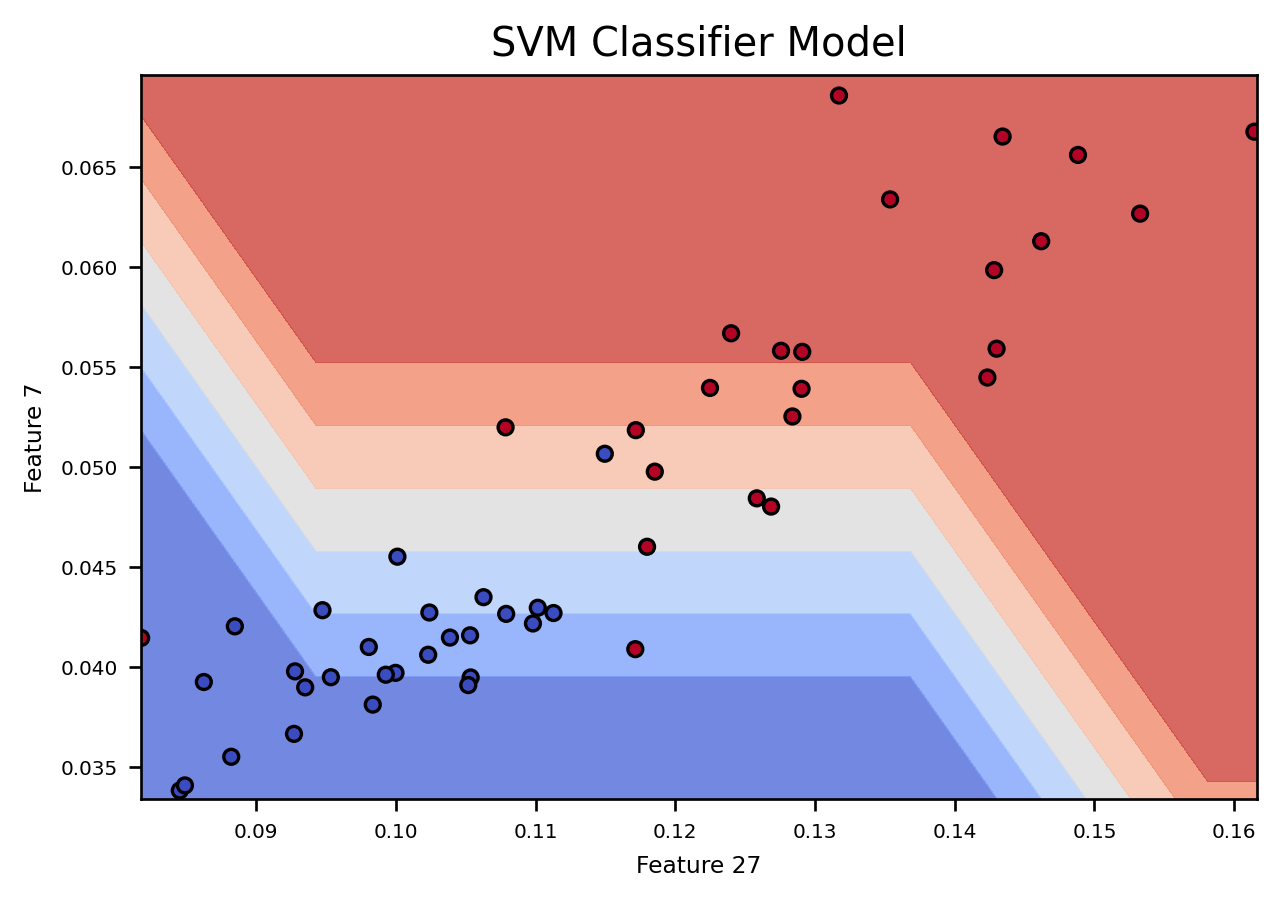

In [27]:
# Your code here
from sklearn.inspection import DecisionBoundaryDisplay
            
list_best = [27,22,20,7] # worst concave points, worst perimeter, worst radius, mean concave points

for i, value_i in enumerate(list_best):
    for j, value_j in enumerate(list_best[i + 1:], start=i + 1):

        # We can pick up two of the best features
        feature0 = value_i
        feature1 = value_j
        
        ## the pairs
        #27 22
        #27 20
        #27 7
        #22 20 
        #22 7
        #20 7
        
        # For each one, extract the percentil 5 and 95. These values are useful to define the limits of our plot
        x05, x95 = np.percentile(X_val[:,feature0],[5,95])
        y05, y95 = np.percentile(X_val[:,feature1],[5,95])
                
        # Define two features. We go to use the best two features identified in the previous step
        feat1, feat2 = X_val[:, feature0], X_val[:, feature1]

        # Train again our using our best model using only the two features 
        svc_best.fit(X_val[:,[feature0,feature1]],y_val)

        # We can plot a DecisionBoundary
        disp = DecisionBoundaryDisplay.from_estimator(
            svc_best,                            # Define the model
            train_set[:,[feature0,feature1]],     # Define the data
            response_method="predict",            # Define the method used to create the boundary
            cmap=plt.cm.coolwarm,                 # Color palette
            alpha=0.8)                         # Transparency
#             xlabel= "Feature 0",                  # Label 1
#             ylabel= "Feature 1")                  # Label 2
        # We can plot the data with its true classes
        plt.scatter(feat1, feat2, c=y_val, cmap=plt.cm.coolwarm, s=20, edgecolors="k")

        # Define the limit values of the plot
        plt.xlim([x05,x95])
        plt.ylim([y05,y95])
        plt.xlabel("Feature " + str(feature0))
        plt.ylabel("Feature " + str(feature1))
        plt.title("SVM Classifier Model")
        plt.show()

### 3.3 Interpretation [1 mark]

From the decision boundaries displayed above, **would you expect the method to extrapolate well or not**?  Give reasons for your answer.

#### Your answer here

The purpose of decision boundaries is to separate different classes or categories using the strongest distinct features
and to see how well those features separate the input into different classes.
For a <b>feature 22 and feature 27</b>, i think it manage to classify between malignant and benign compared to other pair models.
Although there was a present of misclassification, the rate of misclassification was
lower compared to others. The first figure of <b>feature 22 and feature 27</b> have less points in the margin boundary.
The decision boundary for the smaller C = 1, allow more margin violations, 
meaning that some data points fall inside the margin or are misclassified. 
This results in a wider margin that accommodates these margin violations, 
as shown by the wider region between the two classes.
Generally better with a wider margin, as it indicates better generalization 
and reduced overfitting.

## 4. Second Round (15% = 4.5 marks)

After presenting your initial results to the client they come back to you and say that they have done some financial analysis and it would save them a lot of time and money if they did not have to analyse every cell, which is needed to get the "worst" features. Instead, they can quickly get accurate estimates for the "mean" and "standard error" features from a much smaller, randomly selected set of cells.

They ask you to **give them a performance estimate for the same problem, but without using any of the "worst" features.**



### 4.1 New estimate [3.5 marks]

**Calculate an unbiased performance estimate** for this new problem, as requested by the client.

In [28]:
# Your code here
cancer.columns 
cancer_new = cancer[['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error','label']]

In [29]:
from random import sample
#  randomly selected set
cancer_sample = cancer_new.sample(frac=0.6,random_state=101)
cancer_sample = cancer_sample.values

In [30]:
# Your code here
from sklearn.model_selection import train_test_split

bigtrain_set, test_set = train_test_split(cancer_sample, test_size=0.2, random_state=101, stratify=cancer_sample[:,-1])
train_set, val_set = train_test_split(bigtrain_set, test_size=0.25, random_state=101, stratify=bigtrain_set[:,-1])

In [31]:
#Get the X and y for train, val and test
X_train = train_set[:,:-1]
y_train = train_set[:,-1]
X_test = test_set[:,:-1]
y_test = test_set[:,-1]
X_val = val_set[:,:-1]
y_val = val_set[:,-1]
print(f'Shapes are {[X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape]}')

Shapes are [(108, 20), (108,), (36, 20), (36,), (36, 20), (36,)]


In [32]:
# Combine both X_train and X_val
# Set and train the model
big_train_X = np.concatenate((X_train, X_val), axis = 0)
big_train_y = np.concatenate((y_train, y_val), axis = 0)

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

# Classifiers
knn_classifier = Pipeline([
("pre_pipeline",pre_pipeline),
("knn_classifier",KNeighborsClassifier())])

dt_classifier = Pipeline([
("pre_pipeline",pre_pipeline),
("dt_classifier",DecisionTreeClassifier(random_state=101))])

svc_classifier = Pipeline([
("pre_pipeline",pre_pipeline),
("svc_classifier",SVC())])

# Set random seed for reproducibility
np.random.seed(101)
sgd_classifier = Pipeline([
("pre_pipeline",pre_pipeline),
("sgd_classifier",SGDClassifier())])

# Parameters
knn_parameters = {'knn_classifier__n_neighbors' : [3,7,9,11],
                  'knn_classifier__weights':['uniform','distance']}
dt_parameters = {'dt_classifier__criterion' : ['gini'], 'dt_classifier__splitter':['best'],
                'dt_classifier__random_state':[101]}
svc_parameters = {'svc_classifier__C' : [0.1, 1, 10, 100],
                  'svc_classifier__kernel':['linear', 'rbf','poly']}

# Set random seed for reproducibility
np.random.seed(101)
eta0 = [10.0 ** lr_exp for lr_exp in range(-8, 3)]    
learnrate = ['constant','optimal']
sgd_parameters = {'sgd_classifier__early_stopping':[True,False],
                  'sgd_classifier__eta0':eta0,'sgd_classifier__learning_rate':learnrate}


# Searching the best
knn_best = GridSearchCV(knn_classifier, knn_parameters,cv = 5, scoring= 'f1')
dt_best = GridSearchCV(dt_classifier, dt_parameters,cv = 5,scoring='f1')
svc_best = GridSearchCV(svc_classifier,svc_parameters, cv=5,scoring='f1')
sgd_best = GridSearchCV(sgd_classifier, sgd_parameters,cv=5,scoring='f1')

# fit with big_train
knn_best.fit(big_train_X, big_train_y)
dt_best.fit(big_train_X, big_train_y)
svc_best.fit(big_train_X, big_train_y)
sgd_best.fit(big_train_X, big_train_y)


# F1 score
print("KNN F1 score for training:",round(knn_best.best_score_,7),"with parameters",knn_best.best_params_)
print("DT F1 score for training:",round(dt_best.best_score_,7),"with parameters",dt_best.best_params_)
print("SVC F1 score for training:",round(svc_best.best_score_,7),"with parameters",svc_best.best_params_)
print("SGD F1 score for training:",round(sgd_best.best_score_,7),"with parameters",sgd_best.best_params_)


KNN F1 score for training: 0.9302669 with parameters {'knn_classifier__n_neighbors': 3, 'knn_classifier__weights': 'uniform'}
DT F1 score for training: 0.8496711 with parameters {'dt_classifier__criterion': 'gini', 'dt_classifier__random_state': 101, 'dt_classifier__splitter': 'best'}
SVC F1 score for training: 0.9260998 with parameters {'svc_classifier__C': 10, 'svc_classifier__kernel': 'rbf'}
SGD F1 score for training: 0.9332519 with parameters {'sgd_classifier__early_stopping': False, 'sgd_classifier__eta0': 100.0, 'sgd_classifier__learning_rate': 'optimal'}


SGD Performance metrics
Balanced Accuracy: 0.9166666666666666
Recall: 0.9444444444444444
Precision: 0.8947368421052632
AUC: 0.9166666666666666
F1 Score: 0.918918918918919
F-beta Score (beta=0.1): 0.8952033368091762
F-beta Score (beta=10): 0.9439252336448598
SGD optimized parameters: {'sgd_classifier__early_stopping': False, 'sgd_classifier__eta0': 100.0, 'sgd_classifier__learning_rate': 'optimal'}


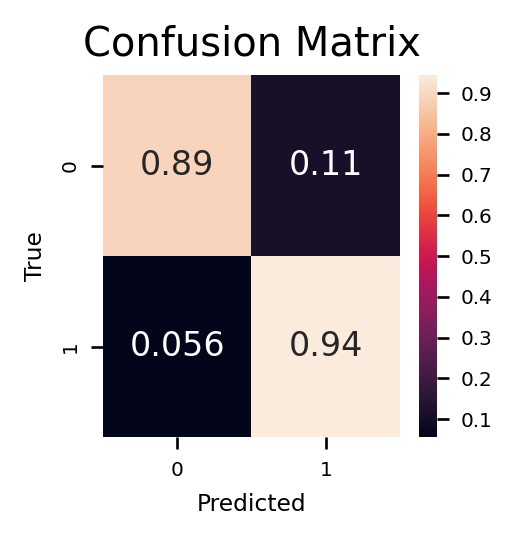

In [34]:
# Your code here
y_pred = sgd_best.predict(X_test)

# Using best estimator to predict testing set
from sklearn import metrics

# Metric Performance
metrics = {
    'Balanced Accuracy': metrics.balanced_accuracy_score(y_test, y_pred),
    'Recall': metrics.recall_score(y_test, y_pred),
    'Precision': metrics.precision_score(y_test, y_pred),
    'AUC': metrics.roc_auc_score(y_test, y_pred),
    'F1 Score': metrics.f1_score(y_test, y_pred),
    'F-beta Score (beta=0.1)': f01_score(y_test, y_pred),
    'F-beta Score (beta=10)': f10_score(y_test, y_pred)
}

print("SGD Performance metrics")
for metric, value in metrics.items():
    print(f"{metric}: {value}")
print("SGD optimized parameters:", sgd_best.best_params_)

# Your code here
cmat_knn = confusion_matrix(y_true=y_test, y_pred=y_pred,normalize="true")
plt.figure(figsize=(2,2))
sns.heatmap(cmat_knn,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 4.2 Performance difference [1 mark]

Do you think the new classifier, that does not use the "worst" features, is:
 - **as good as the previous classifier** (that uses all the features)
 - **better than the previous classifier**
 - **worse than the previous classifier**
 
Give reasons for your answer.

#### Your answer here
The new classifier without the <b>"worst"</b> features is worse than previous classifier. 
The F1 score in testing set was decreasing from <b>0.964285 (96.43%)</b> in previous classifier to <b> 0.91891 (91.89%)</b>  in new classifier.
This is expected to decrease as the strong predictors that distinct the patients either have cancer or vice verca had been removed from the dataset.

Not just that, the difference between the training and testing F1 scores in this new classifier  is <b>(0.93325 - 0.91891 = 0.01434) </b> suggests that the model has learned to perform very well on the training data but struggles to perform equally well on new unseen data. This discrepancy is characteristic of overfitting.